# Liver analysis 002

**Date**: 2020-09-10<br>
**Author**: Alma Andersson<br>
**Description**:<br>

Analysis of a single liver sample, mainly to illustrate certain concepts and show what sort of analysis that can be made. The analysis include plotting of gene expression levels as a function of distance from a vein (of a given type), classification of veins based on their surrounding gene expression, and a survey of how the spot expression compares to certain types of tissue.



## Setup

Load data the necessary packages and data for the analysis, also specify certain constants which will be used throughout the analysis.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
import anndata as ad

from skmisc.loess import loess

import os
import os.path as osp
from os import listdir

import matplotlib.pyplot as plt

from PIL import Image

from functools import reduce

from scipy.spatial.distance import cdist

import utils as ut


In [ ]:
DATA_DIR = "/home/alma/w-projects/help/franzi/repo/data/h5ad-cca"
VARIAB

In [3]:

PTHS = list(filter(lambda x: x.split(".")[-1] == "h5ad",os.listdir(DATA_DIR)))
PTHS = {p.split(".")[0]:osp.join(DATA_DIR,p) for p in PTHS }

In [4]:
#exclude = ["CN65-E1","CN65-C1","CN65-C2","CN65-D2","CN16-D1"]
exclude = ["CN65-CCA-C1"]
#exclude = []
data_set = {n:ad.read_h5ad(p) for n,p in PTHS.items()}

for ex in exclude:
    data_set.pop(ex)

data_set

{'CN73-CCA-C1': AnnData object with n_obs × n_vars = 673 × 9655
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN16-CCA-D2': AnnData object with n_obs × n_vars = 487 × 9655
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN16-CCA-E2': AnnData object with n_obs × n_vars = 487 × 9655
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN65-CCA-C2': AnnData object with n_obs × n_vars = 626 × 9655
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN65-CCA-E1': AnnData object with n_obs × n_vars = 590 × 9655
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN65-CCA-D1': AnnData object with n_obs × n_vars = 663 × 9655
     obs: '_x', '_y', 'x', 'y'
     var: 'gene'
     uns: 'img', 'mask'
     obsm: 'vein_distances',
 'CN73-CCA

In [5]:
# specify path to folder where gene lists are kept
gene_list_pth = "/home/alma/w-projects/help/franzi/repo/data/gene-lists/veins"

In [6]:
use_short_filter = True

pths = listdir(gene_list_pth)
if use_short_filter:
    pths = list(filter(lambda x: "short" in x,pths))
else:
    pths = list(filter(lambda x: "short" not in x,pths))
# read gene lists
genes = dict()

for filename in pths:
    name = '.'.join(filename.split(".")[0:-1])
    with open(osp.join(gene_list_pth,filename),"r+") as f:
        _gs = f.readlines()
        _gs = [x.replace("\n","") for x in _gs]
        genes.update({name:_gs})
        
# create an additional entry called "all" by joining 
# all existing lists
genes["all"] = reduce(lambda x,y : x + y,list(genes.values()))

In [8]:
# CONSTANTS

# SCALE_FACTOR : scaling factor px to um
SCALE_FACTOR = 0.26

In [9]:
data_set['CN16-CCA-D1'].uns["mask"]

x     y     type  id
0       1501   645  central   0
1       1479   646  central   0
2       1480   646  central   0
3       1481   646  central   0
4       1482   646  central   0
...      ...   ...      ...  ..
331983  1595  2247  unknown  48
331984  1590  2248  unknown  48
331985  1591  2248  unknown  48
331986  1592  2248  unknown  48
331987  1593  2248  unknown  48

[331988 rows x 4 columns]

Visualize the data to make sure everything looks as expected

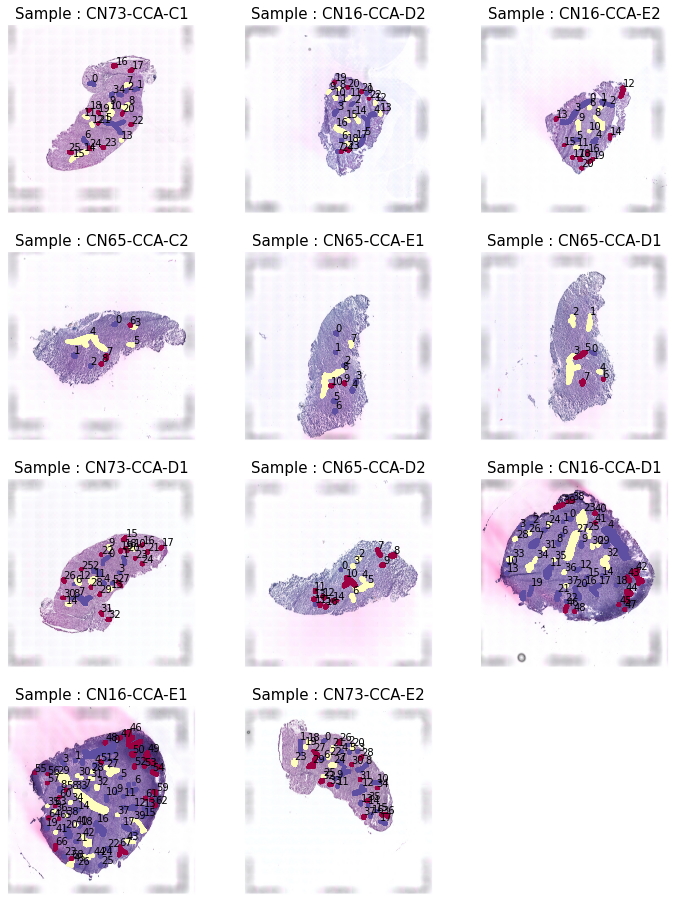

In [10]:
n_veins = len(data_set)
spot_size = 20
side_size =4

fig,ax = ut.get_figure(n_veins,n_cols = 3, side_size = side_size)

for k,(sample_id,data) in enumerate(data_set.items()):
    
    ut.plot_veins(ax[k],data,
                  show_image=True,
                  show_id=True)
    ax[k].set_title("Sample : {}".format(sample_id),
                   fontsize = 15,
                   )
    
plt.show()

In [11]:
for sample,data in data_set.items():
    log_ratio = np.log(data.obsm["vein_distances"].dist_type_central) -\
    np.log(data.obsm["vein_distances"].dist_type_portal)
    data_set[sample].obsm["vein_distances"]["log(central/portal)"] = log_ratio

## Analysis : Expression by distance

Model gene expression as a function of the distance to the nearest gene. We use loess regression to get an approximation of the curve that describe the trends in the data. Envelopes (blue) represent 1 standard error.

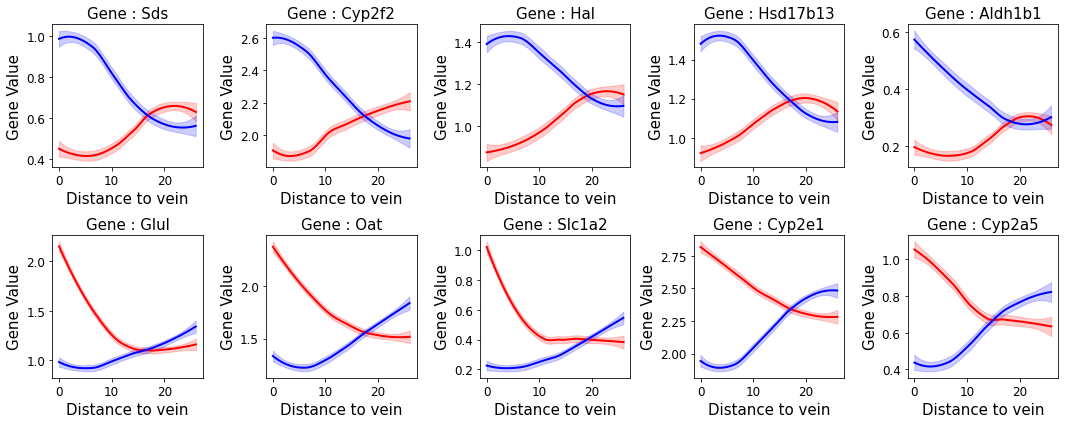

In [21]:

# set vein type to plot
vein_type = "all"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = 100

# which genes to be assessed
vein_genes = genes[vein_type]

# distance values to use

colormap = dict(central = {"envelope":"red",
                           "fitted":"red",
                           "background":"red"},
               portal = {"envelope":"blue",
                         "fitted":"blue",
                         "background":"blue"},
               )

fig,ax = ut.get_figure(len(vein_genes),
                       n_cols = 5,
                       side_size = 3,
                      )

# iterate over each gene
for k,gene in enumerate(vein_genes):
    
    
    for vt in ["central","portal"]:

        xs = np.array([])
        ys = np.array([])

        for data in data_set.values():
            if gene not in data.var.gene.values:
                print("can't find {}".format(gene))
                continue

            min_dist = data.obsm["vein_distances"]["dist_type_" + vt].values
            xs = np.append(xs,min_dist)
            ys = np.append(ys,data.obs_vector(gene))
        
        smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
        ut.plot_expression_by_distance(ax[k],
                                       data = smoothed,
                                       curve_label = vt,
                                       color_scheme = colormap[vt],
                                       include_background = False,
                                       feature_type = "Gene",
                                       feature = gene,
                                       distance_scale_factor = SCALE_FACTOR,
                                       title_fontsize = 18,
                                       label_fontsize = 15,
                                       tick_fontsize = 12,
                                      )


fig.tight_layout()

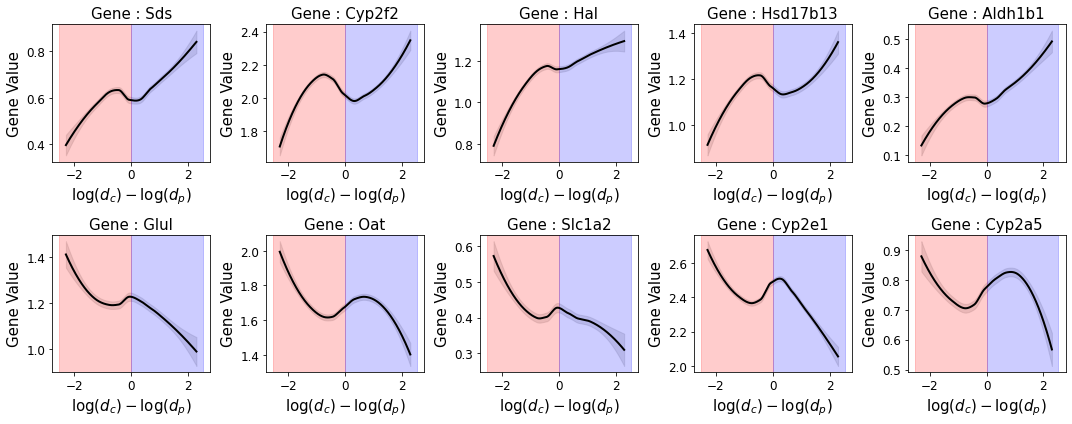

In [22]:

# set vein type to plot
vein_type = "all"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = np.log(10)

# which genes to be assessed
vein_genes = genes[vein_type]


fig,ax = ut.get_figure(n_elements=len(vein_genes),
                       n_cols = 5,
                       side_size = 3,
                      )
# --- plot settings

# iterate over each gene
#for k,gene in enumerate(vein_genes):
for k,gene in enumerate(vein_genes):

    xs = np.array([])
    ys = np.array([])

    for data in data_set.values():
        if gene not in data.var.gene.values:
            continue

        dist = data.obsm["vein_distances"]["log(central/portal)"].values
        xs = np.append(xs,dist)
        ys = np.append(ys,data.obs_vector(gene))

    smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
    ut.plot_expression_by_distance(ax[k],
                                   smoothed,
                                   flavor ="logodds",
                                   feature = gene,
                                   color_scheme = {"envelope":"gray"},
                                   include_background = False,
                                   feature_type = "Gene",
                                   title_fontsize = 18,
                                   label_fontsize = 15,
                                   tick_fontsize = 12,
                                  )

fig.tight_layout()
plt.show()

## Analysis : Classification

Begin by assembling representative (mean expression) vectors for neighborhoods around respective vein type and each individual vein. Then proceed to train a predictor (Logistic Regression) and see how it performs on the given data (this is just a prototype).

### Prepare data
Create the necessary mean expression profiles

In [24]:
import utils as ut
vein_data = ut.VeinData(data_set = data_set,
                        radius = 80,
                        use_genes = genes["all"],
                        weight_by_distance = True,
                        sigma = 20,
                        verbose = True,
                       )

model = ut.Model(vein_data,
                 verbose=False)


Sample : CN73-CCA-C1 | Vein 0 | Spots used : 17
Sample : CN73-CCA-C1 | Vein 1 | Spots used : 15
Sample : CN73-CCA-C1 | Vein 2 | Spots used : 13
Sample : CN73-CCA-C1 | Vein 3 | Spots used : 12
Sample : CN73-CCA-C1 | Vein 4 | Spots used : 14
Sample : CN73-CCA-C1 | Vein 5 | Spots used : 42
Sample : CN73-CCA-C1 | Vein 6 | Spots used : 19
Sample : CN73-CCA-C1 | Vein 7 | Spots used : 15
Sample : CN73-CCA-C1 | Vein 8 | Spots used : 20
Sample : CN73-CCA-C1 | Vein 9 | Spots used : 13
Sample : CN73-CCA-C1 | Vein 10 | Spots used : 20
Sample : CN73-CCA-C1 | Vein 11 | Spots used : 12
Sample : CN73-CCA-C1 | Vein 12 | Spots used : 13
Sample : CN73-CCA-C1 | Vein 13 | Spots used : 7
Sample : CN73-CCA-C1 | Vein 14 | Spots used : 22
Sample : CN73-CCA-C1 | Vein 15 | Spots used : 15
Sample : CN73-CCA-C1 | Vein 16 | Spots used : 11
Sample : CN73-CCA-C1 | Vein 17 | Spots used : 14
Sample : CN73-CCA-C1 | Vein 18 | Spots used : 9
Sample : CN73-CCA-C1 | Vein 19 | Spots used : 12
Sample : CN73-CCA-C1 | Vein 20 |

Sample : CN16-CCA-D1 | Vein 20 | Spots used : 25
Sample : CN16-CCA-D1 | Vein 21 | Spots used : 19
Sample : CN16-CCA-D1 | Vein 22 | Spots used : 9
Sample : CN16-CCA-D1 | Vein 23 | Spots used : 37
Sample : CN16-CCA-D1 | Vein 24 | Spots used : 11
Sample : CN16-CCA-D1 | Vein 25 | Spots used : 19
Sample : CN16-CCA-D1 | Vein 26 | Spots used : 12
Sample : CN16-CCA-D1 | Vein 27 | Spots used : 54
Sample : CN16-CCA-D1 | Vein 28 | Spots used : 10
Sample : CN16-CCA-D1 | Vein 29 | Spots used : 11
Sample : CN16-CCA-D1 | Vein 30 | Spots used : 12
Sample : CN16-CCA-D1 | Vein 31 | Spots used : 10
Sample : CN16-CCA-D1 | Vein 32 | Spots used : 27
Sample : CN16-CCA-D1 | Vein 33 | Spots used : 7
Sample : CN16-CCA-D1 | Vein 34 | Spots used : 28
Sample : CN16-CCA-D1 | Vein 35 | Spots used : 10
Sample : CN16-CCA-D1 | Vein 36 | Spots used : 12
Sample : CN16-CCA-D1 | Vein 37 | Spots used : 10
Sample : CN16-CCA-D1 | Vein 38 | Spots used : 3
Sample : CN16-CCA-D1 | Vein 39 | Spots used : 10
Sample : CN16-CCA-D1 | 

### Train and Predict with classifier

use the `LogisticRegression` module from `sklearn` to create a classifier (binary classification into portal and central veins). We use a l2 penalty to reduce the extent of overfitting and also prevent the weights to blow up.

In [28]:
results = model.cross_validation(k=1,
                                 exclude_class="unknown",
                                 by = "sample",
                                 verbose = False,
                                 )
display(results)
print("Average Accuracy {}".format(results["accuracy"].mean()))

pred_on                                           train_on  accuracy
0   CN73-CCA-E2  CN73-CCA-C1, CN16-CCA-D2, CN16-CCA-E2, CN65-CC...  0.730769
1   CN16-CCA-E1  CN73-CCA-C1, CN16-CCA-D2, CN16-CCA-E2, CN65-CC...  0.869565
2   CN16-CCA-D1  CN73-CCA-C1, CN16-CCA-D2, CN16-CCA-E2, CN65-CC...  0.868421
3   CN65-CCA-D2  CN73-CCA-C1, CN16-CCA-D2, CN16-CCA-E2, CN65-CC...  0.571429
4   CN73-CCA-D1  CN73-CCA-C1, CN16-CCA-D2, CN16-CCA-E2, CN65-CC...  0.933333
5   CN65-CCA-D1  CN73-CCA-C1, CN16-CCA-D2, CN16-CCA-E2, CN65-CC...  1.000000
6   CN65-CCA-E1  CN73-CCA-C1, CN16-CCA-D2, CN16-CCA-E2, CN65-CC...  0.222222
7   CN65-CCA-C2  CN73-CCA-C1, CN16-CCA-D2, CN16-CCA-E2, CN65-CC...  0.666667
8   CN16-CCA-E2  CN73-CCA-C1, CN16-CCA-D2, CN65-CCA-C2, CN65-CC...  1.000000
9   CN16-CCA-D2  CN73-CCA-C1, CN16-CCA-E2, CN65-CCA-C2, CN65-CC...  0.947368
10  CN73-CCA-C1  CN16-CCA-D2, CN16-CCA-E2, CN65-CCA-C2, CN65-CC...  0.937500

Average Accuracy 0.7952067923177762


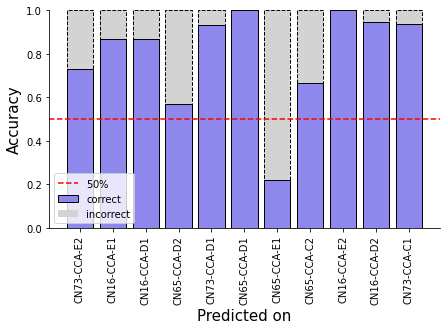

In [29]:
fig,ax = ut.visualize_prediction_result(results)

Finally we can visualize the prediction on the tissue, showing the predicted and true labels for respective vein

In [30]:
results = model.cross_validation(k=1,
                                 exclude_class="unknown",
                                 by = "individual",
                                 verbose = False,
                                 )

In [31]:
results

pred_on    train_on  accuracy
0    CN65  CN73, CN16  0.555556
1    CN16  CN73, CN65  0.852174
2    CN73  CN16, CN65  0.824561

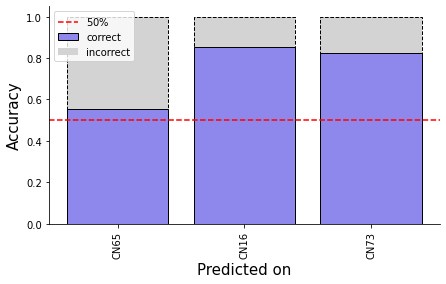

In [32]:
fig,ax = ut.visualize_prediction_result(results)

## Prediction on unknown veins

In [31]:
model.fit(train_on = "all",
          verbose=True,
          exclude_class="unknown")

predict = model.predict(predict_on="all",
                        exclude_class=["portal","central"],
                        return_probs = True,
                       )


[INFO] : Training on samples: all
[INFO] : Accuracy on training data is >> 84.422%
all


Vein : CN73-CCA-C1_16 | P(central) : 0.9230730180648884 | P(portal) : 0.07692698193511159


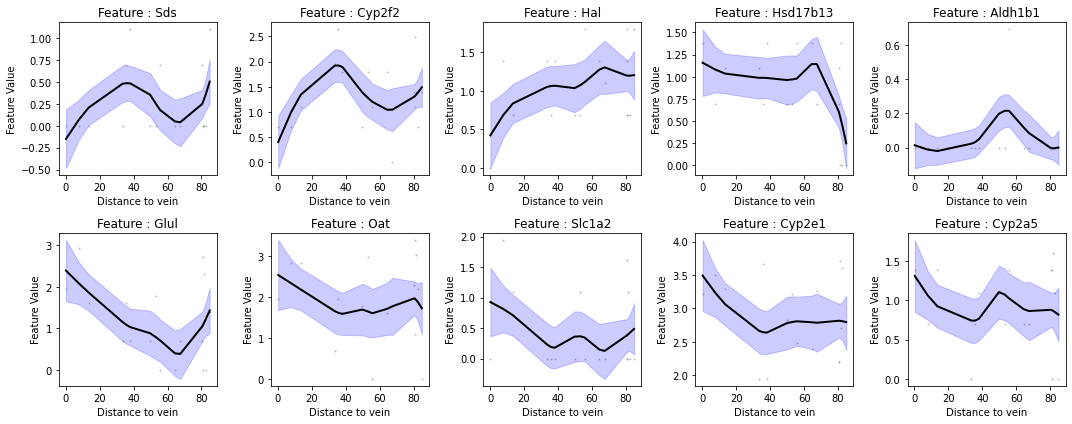

Vein : CN73-CCA-C1_17 | P(central) : 0.8584949020627748 | P(portal) : 0.14150509793722527


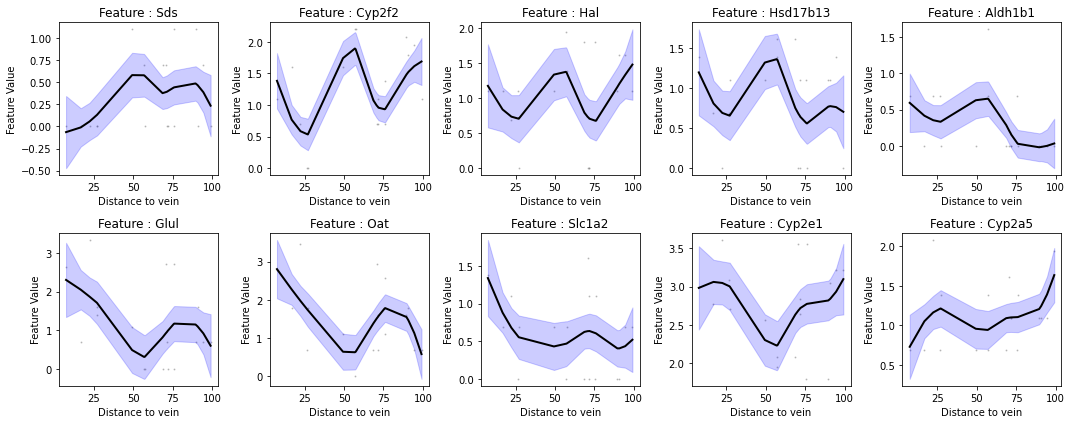

Vein : CN73-CCA-C1_18 | P(central) : 0.14185150264774027 | P(portal) : 0.8581484973522597


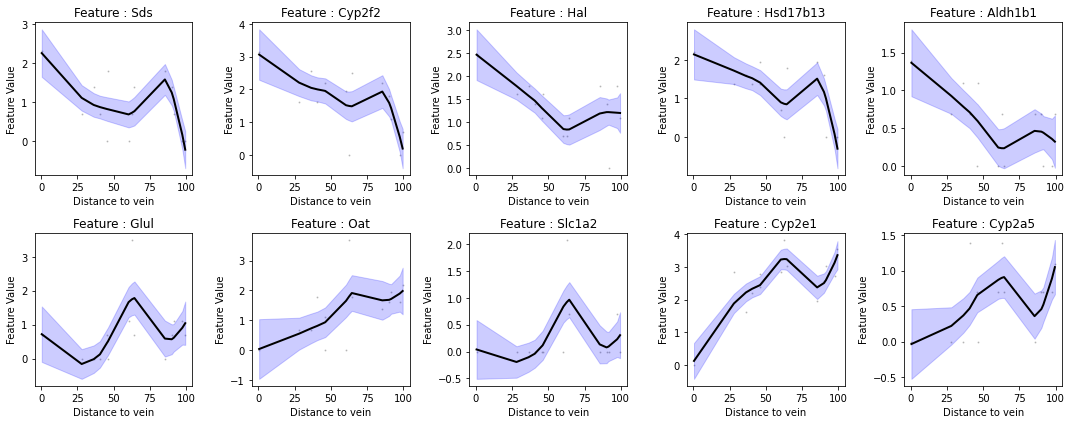

Vein : CN73-CCA-C1_19 | P(central) : 0.8368278861779108 | P(portal) : 0.16317211382208918


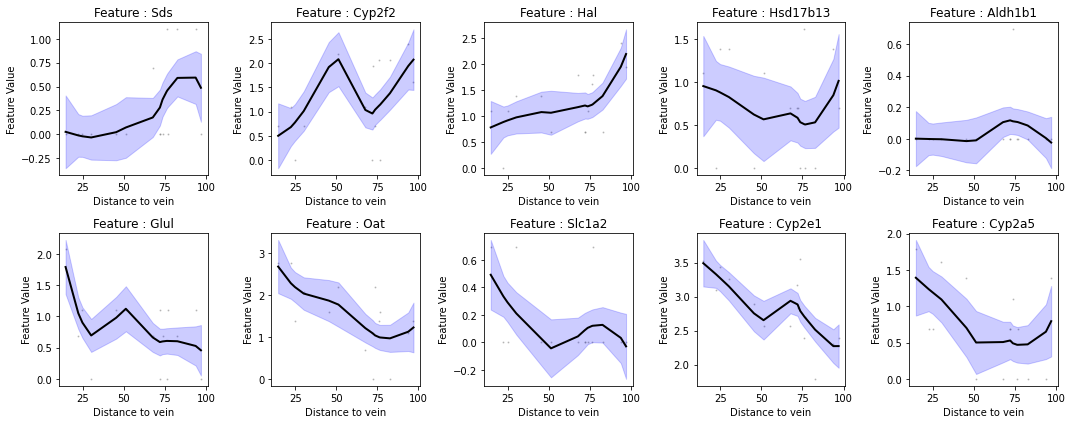

Vein : CN73-CCA-C1_20 | P(central) : 0.29501262543860496 | P(portal) : 0.704987374561395


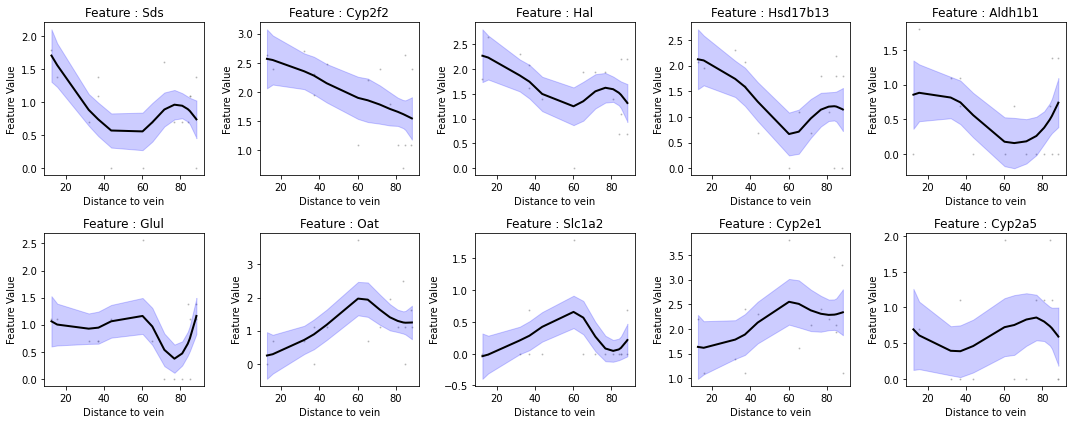

Vein : CN73-CCA-C1_21 | P(central) : 0.851457324052182 | P(portal) : 0.148542675947818


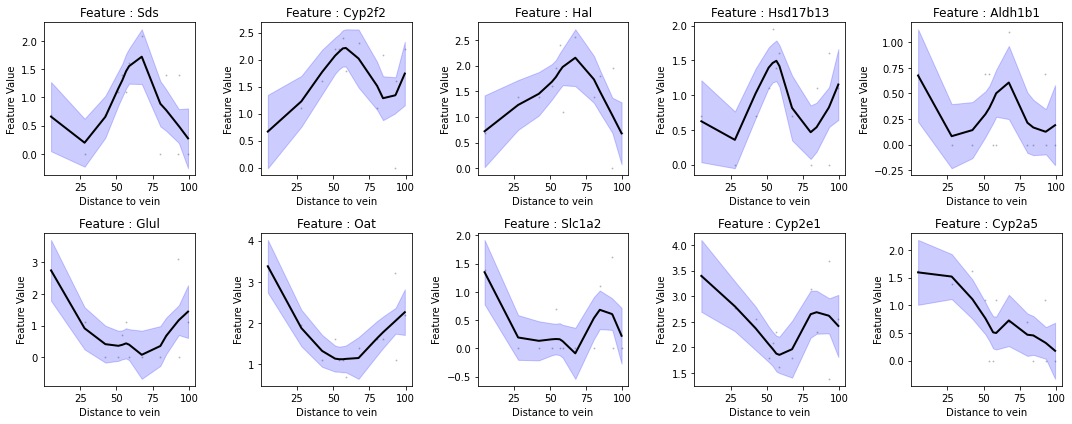

Vein : CN73-CCA-C1_22 | P(central) : 0.9294019623592666 | P(portal) : 0.07059803764073339


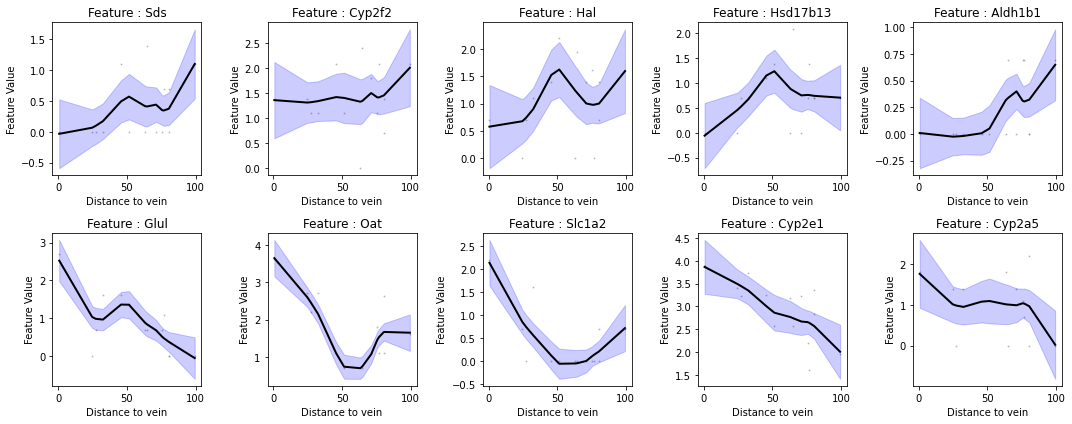

Vein : CN73-CCA-C1_23 | P(central) : 0.2728009137329006 | P(portal) : 0.7271990862670994


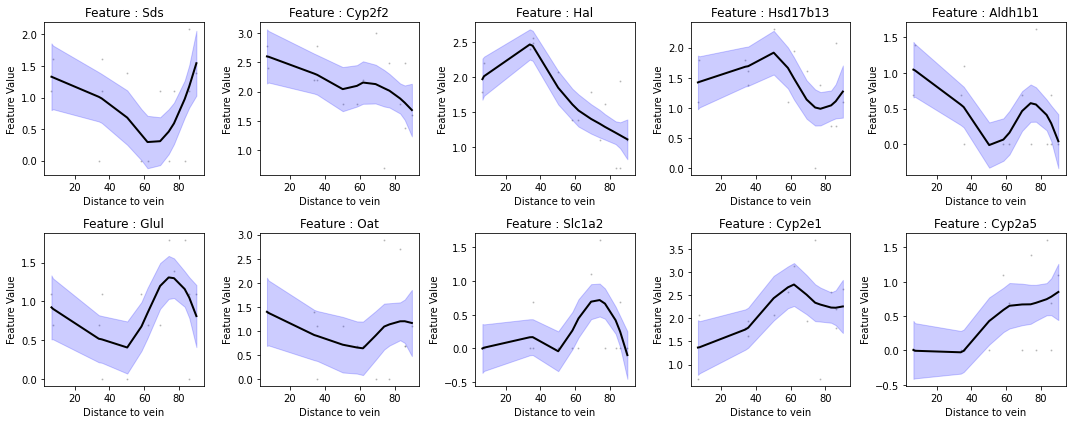

Vein : CN73-CCA-C1_24 | P(central) : 0.9046503440498981 | P(portal) : 0.09534965595010186


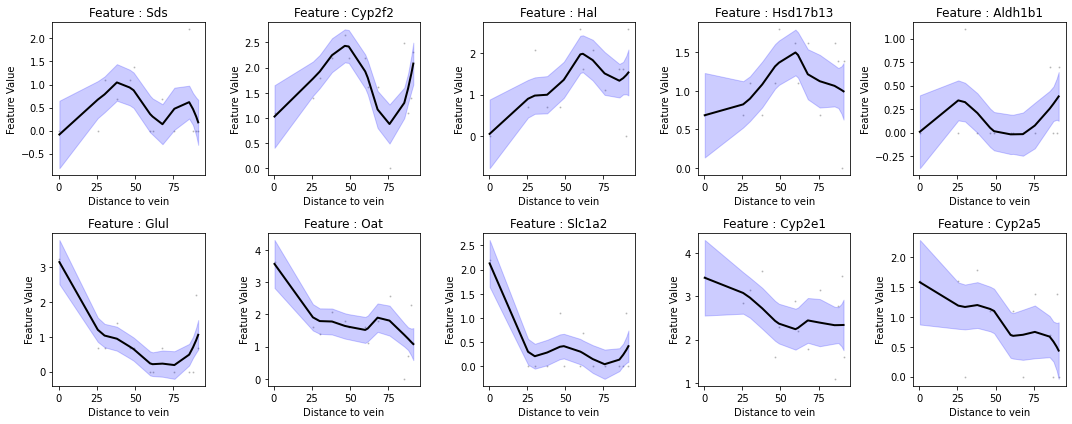

Vein : CN73-CCA-C1_25 | P(central) : 0.4335483873099568 | P(portal) : 0.5664516126900432


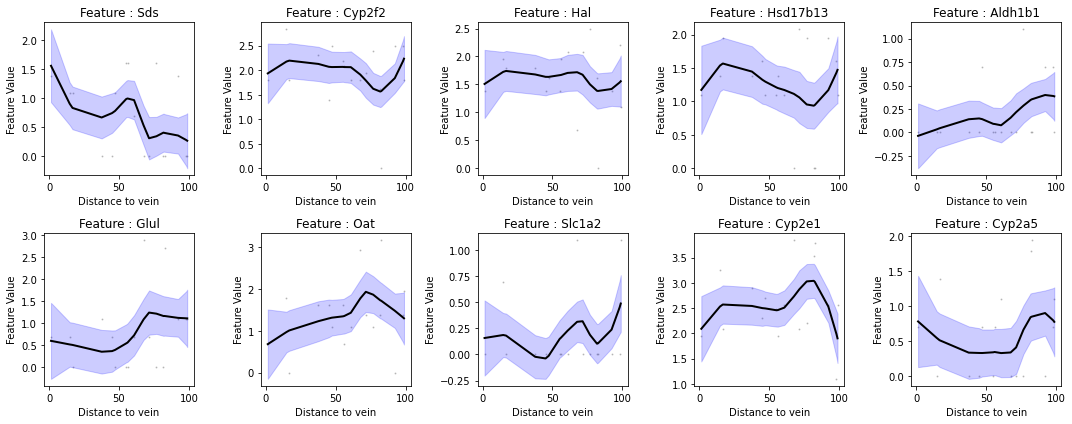

Vein : CN16-CCA-D2_19 | P(central) : 0.40224397073765683 | P(portal) : 0.5977560292623432


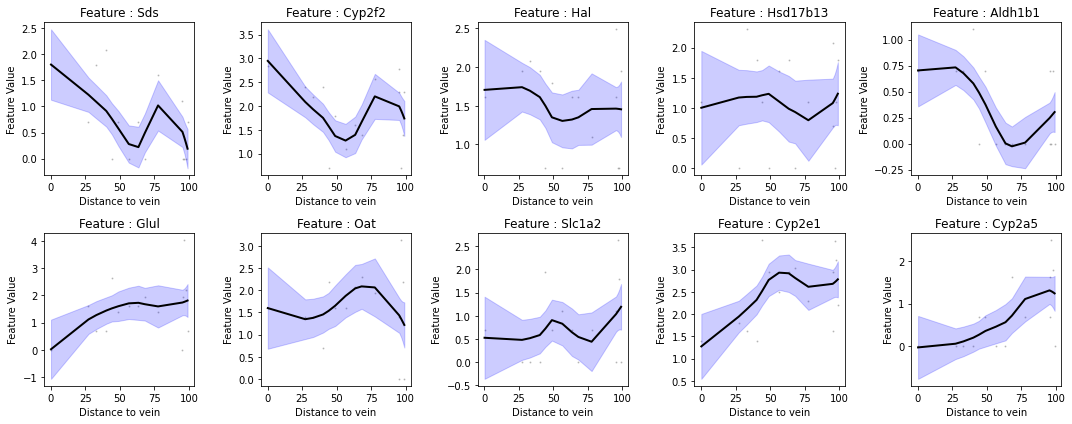

Vein : CN16-CCA-D2_20 | P(central) : 0.34192000264265665 | P(portal) : 0.6580799973573433


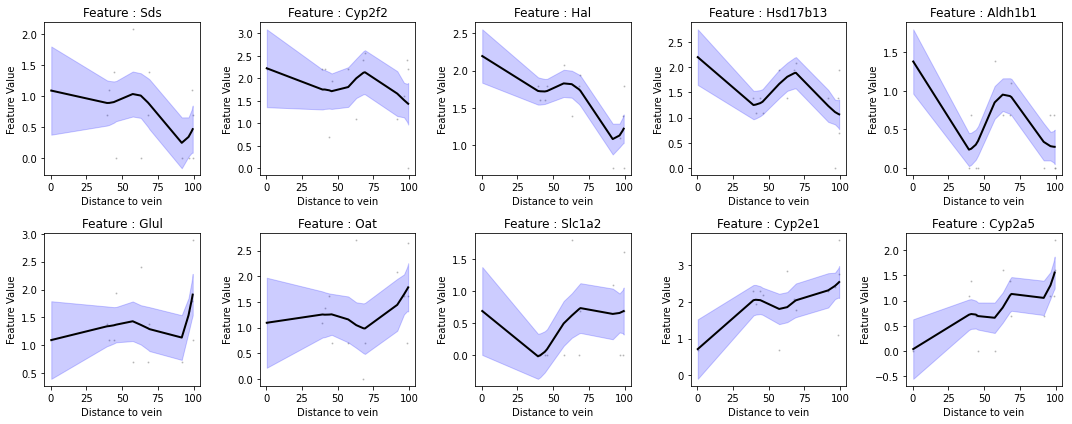

Vein : CN16-CCA-D2_21 | P(central) : 0.31307509928862043 | P(portal) : 0.6869249007113796


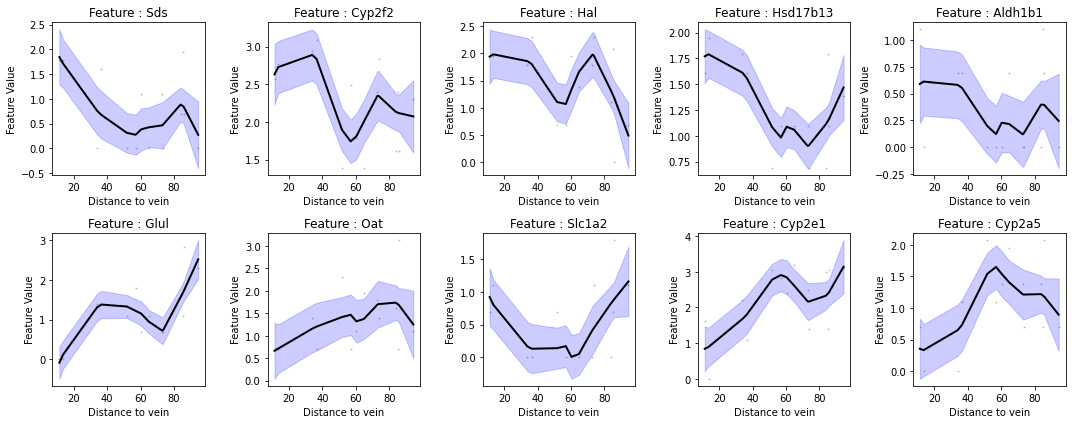

Vein : CN16-CCA-D2_22 | P(central) : 0.46942955958637356 | P(portal) : 0.5305704404136264


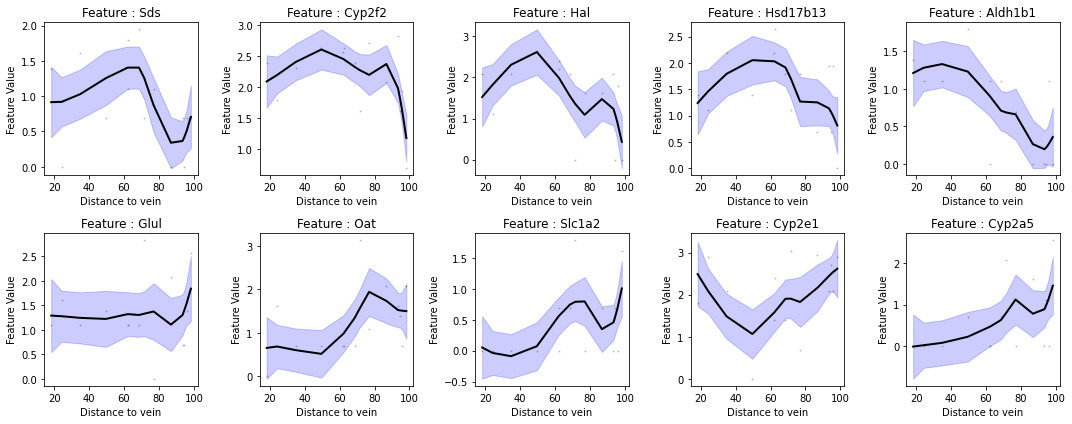

Vein : CN16-CCA-D2_23 | P(central) : 0.8643103367653937 | P(portal) : 0.1356896632346063


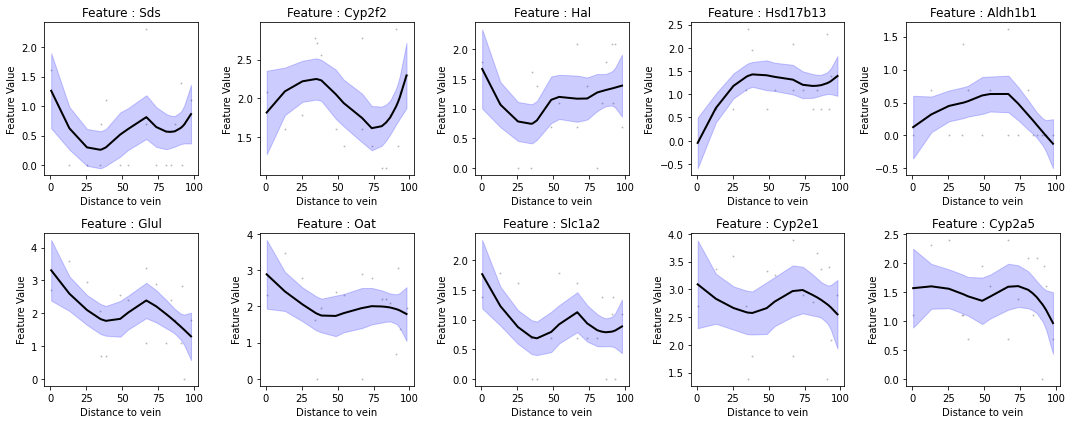

Vein : CN16-CCA-D2_24 | P(central) : 0.9354174341422342 | P(portal) : 0.06458256585776574


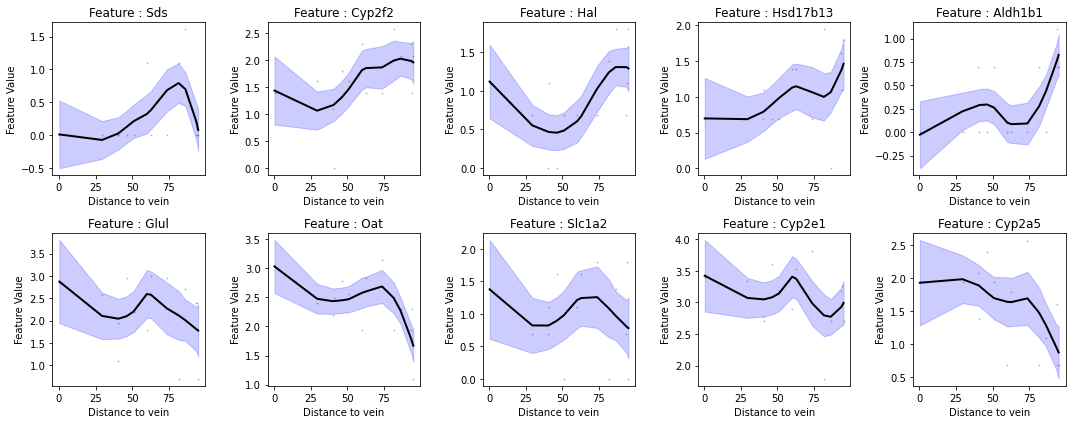

Vein : CN16-CCA-E2_12 | P(central) : 0.1597771930758387 | P(portal) : 0.8402228069241613


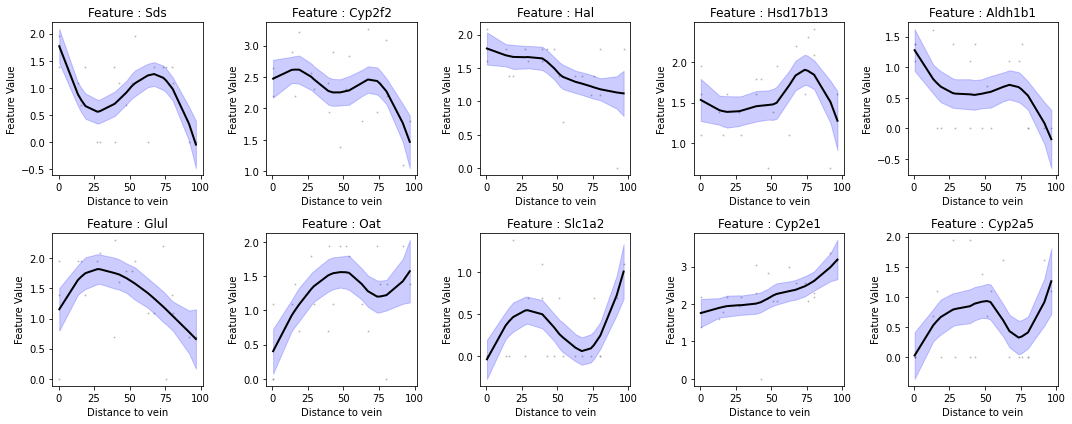

Vein : CN16-CCA-E2_13 | P(central) : 0.26215503769355053 | P(portal) : 0.7378449623064495


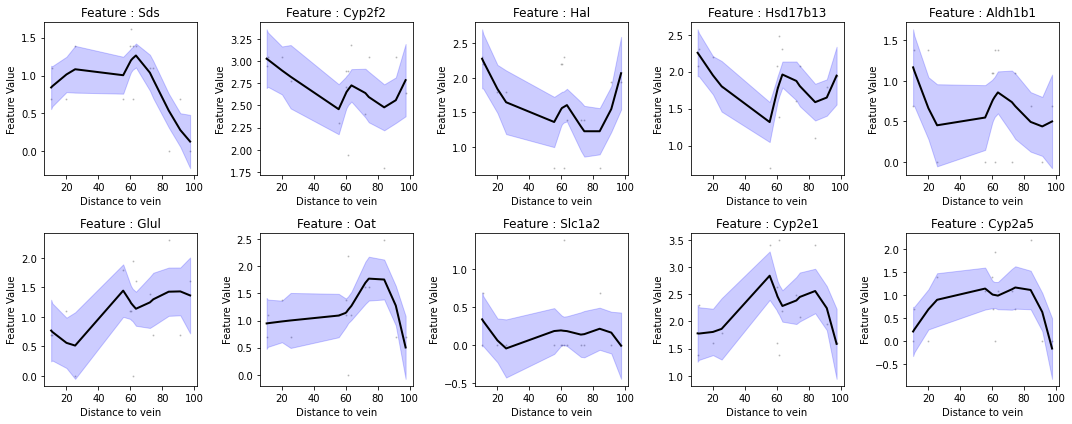

Vein : CN16-CCA-E2_14 | P(central) : 0.1790958308055668 | P(portal) : 0.8209041691944332


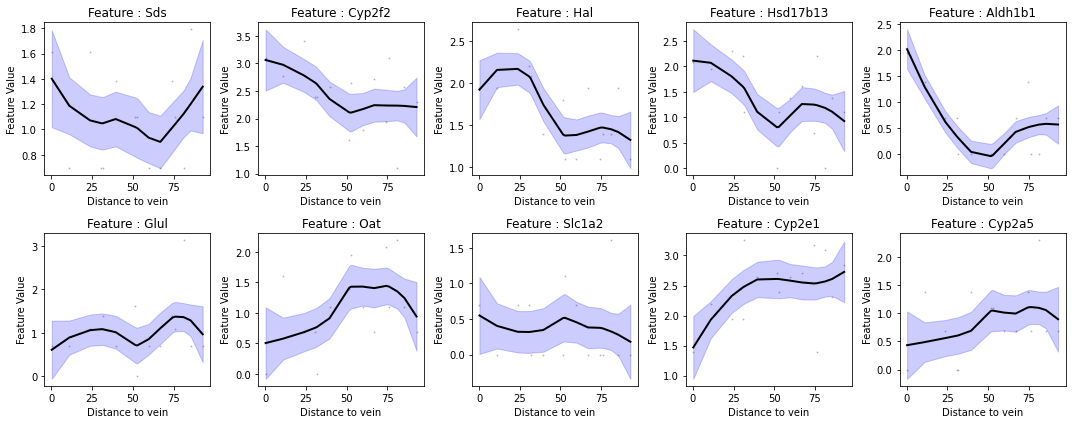

Vein : CN16-CCA-E2_15 | P(central) : 0.3449919403233602 | P(portal) : 0.6550080596766398


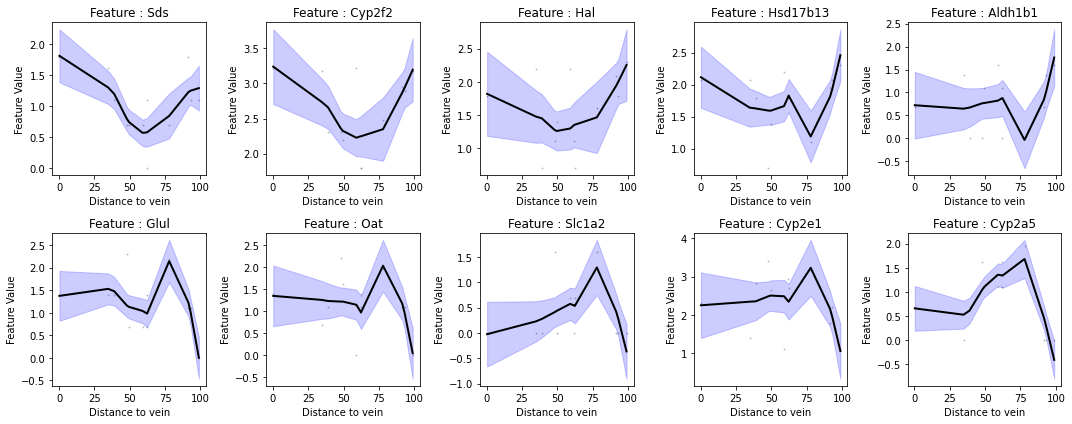

Vein : CN16-CCA-E2_16 | P(central) : 0.4196329218109166 | P(portal) : 0.5803670781890834


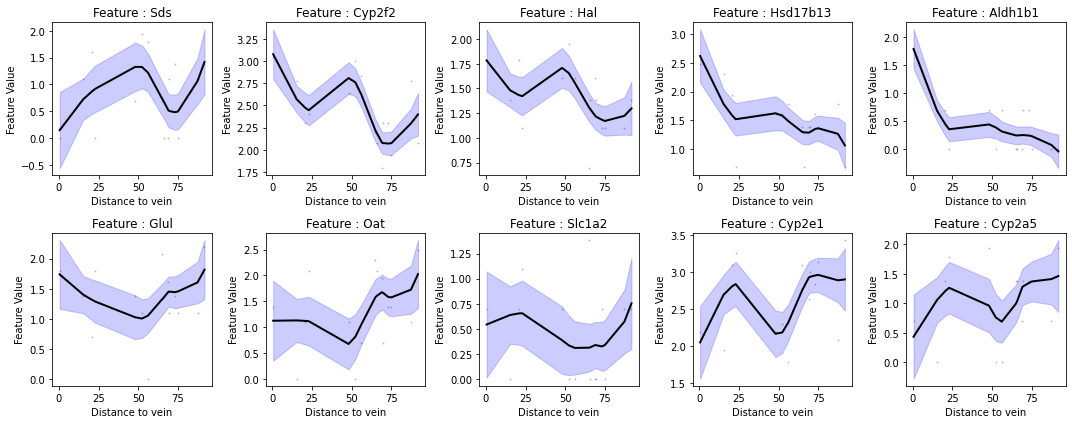

Vein : CN16-CCA-E2_17 | P(central) : 0.32583066597525 | P(portal) : 0.67416933402475


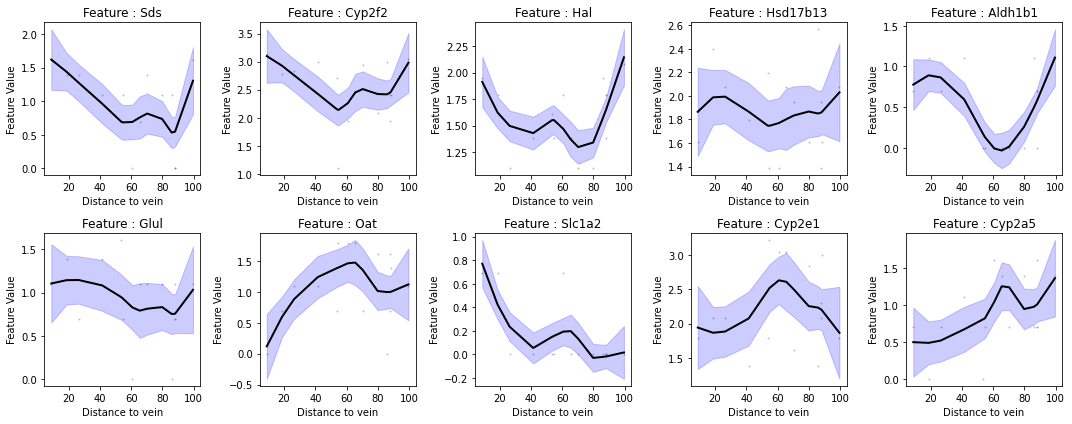

Vein : CN16-CCA-E2_18 | P(central) : 0.2778450643414667 | P(portal) : 0.7221549356585333


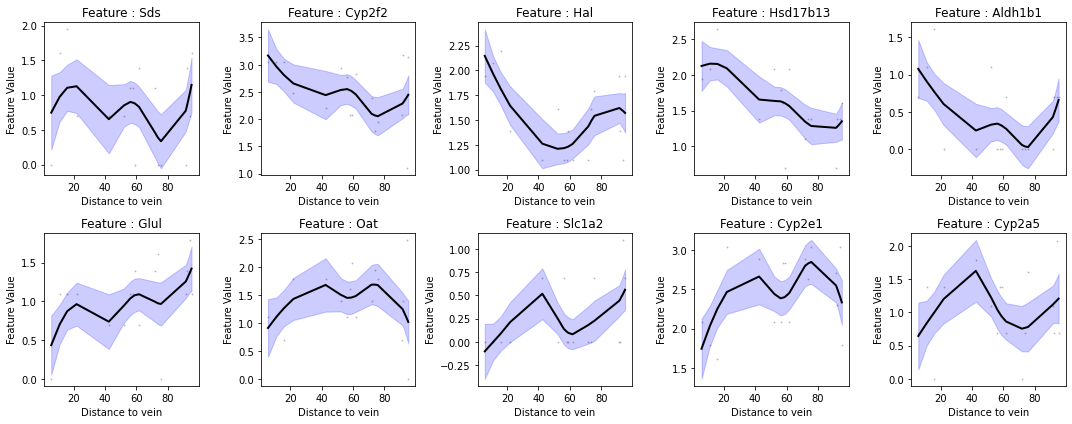

Vein : CN16-CCA-E2_19 | P(central) : 0.3652500531048668 | P(portal) : 0.6347499468951332


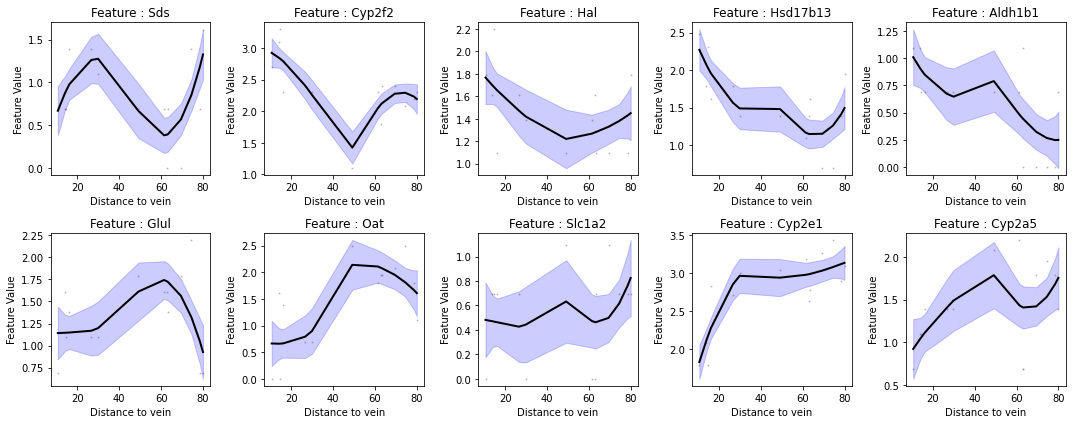

Vein : CN16-CCA-E2_20 | P(central) : 0.20617908000187324 | P(portal) : 0.7938209199981268


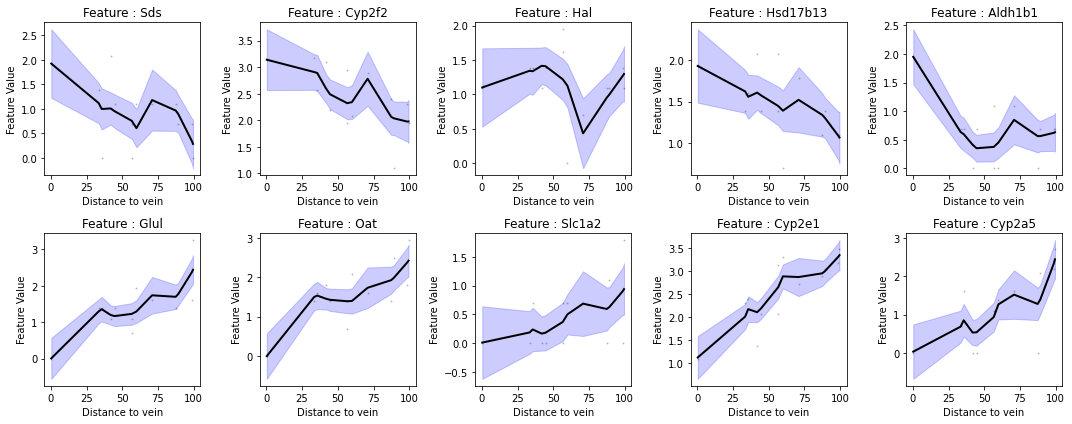

Vein : CN65-CCA-C2_6 | P(central) : 0.2223032314319474 | P(portal) : 0.7776967685680526


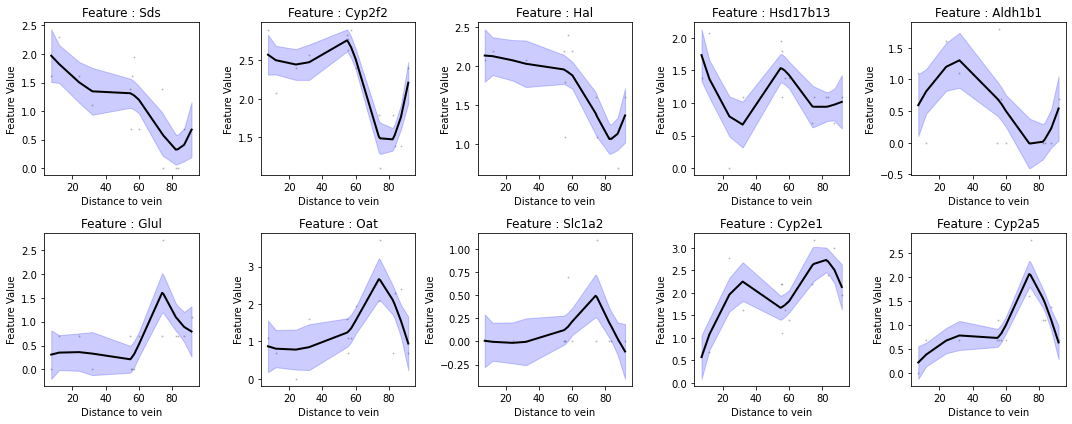

Vein : CN65-CCA-C2_7 | P(central) : 0.9306292727332377 | P(portal) : 0.06937072726676231


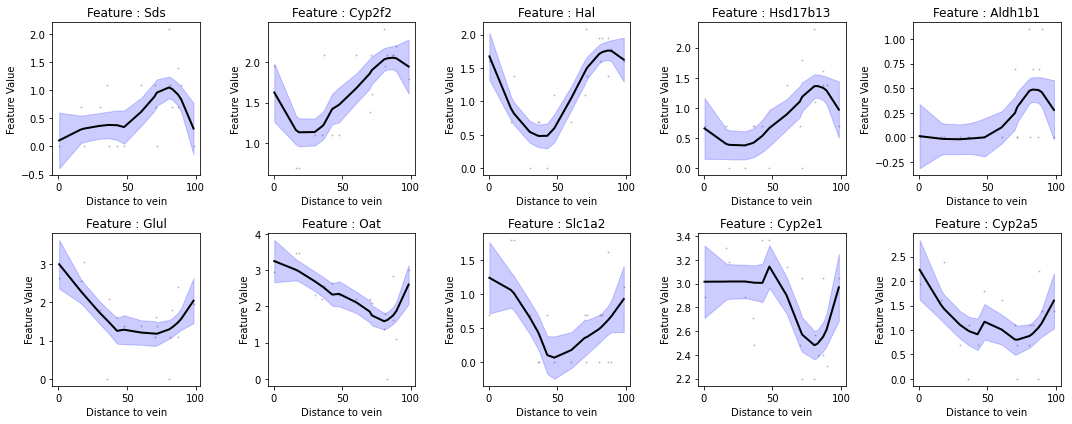

Vein : CN65-CCA-C2_8 | P(central) : 0.6566313205740948 | P(portal) : 0.34336867942590515


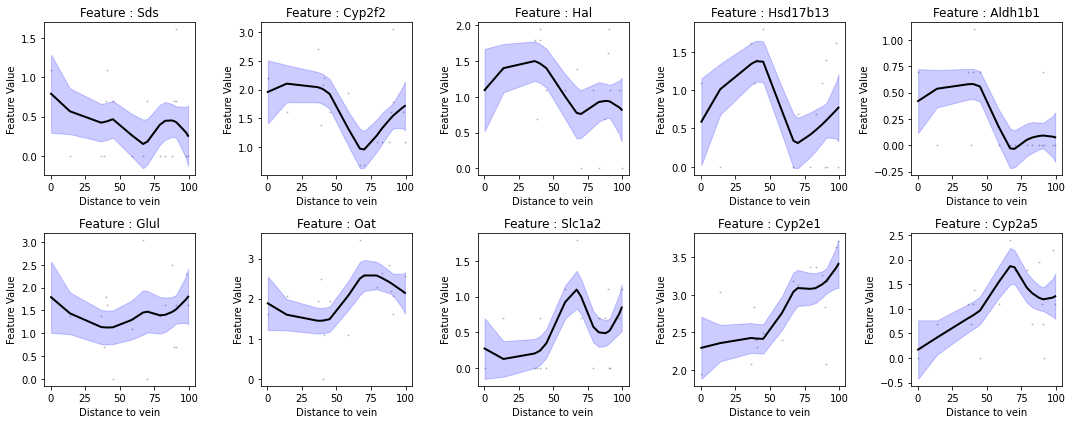

Vein : CN65-CCA-E1_9 | P(central) : 0.9666284904120347 | P(portal) : 0.03337150958796527


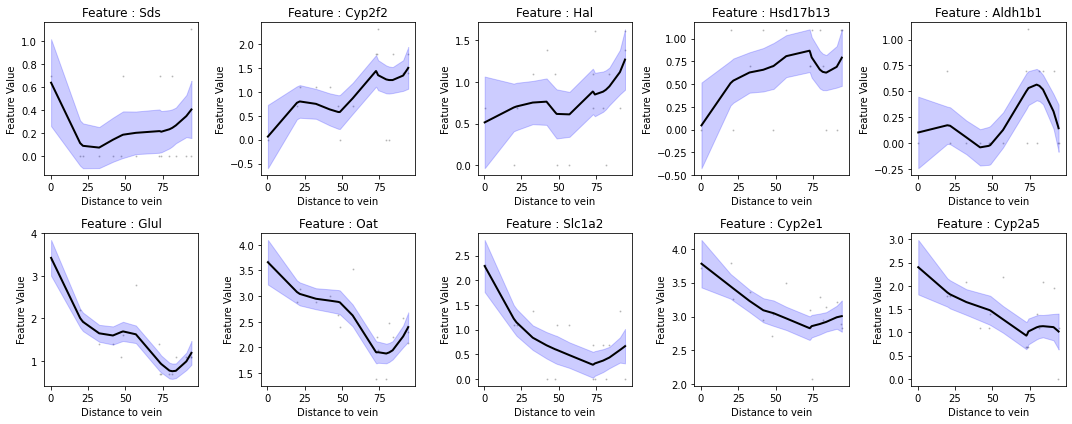

Vein : CN65-CCA-E1_10 | P(central) : 0.3097237990122914 | P(portal) : 0.6902762009877086


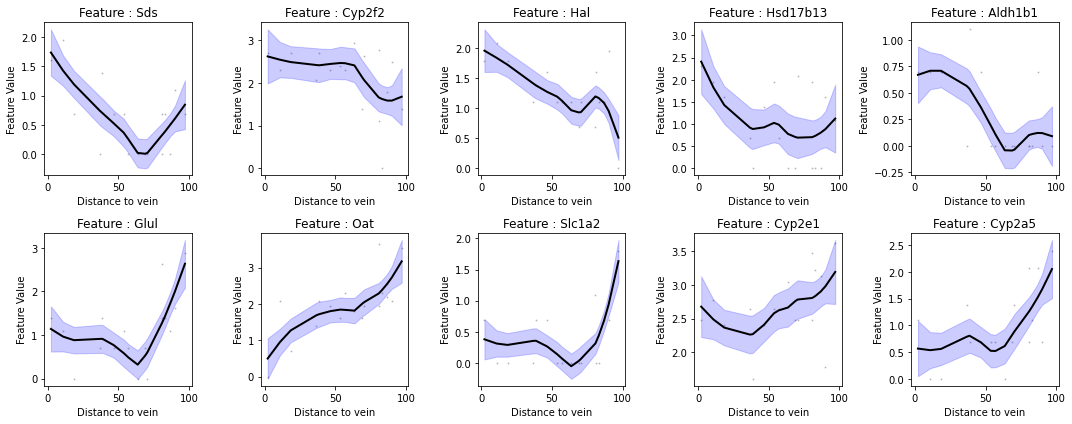

Vein : CN65-CCA-D1_5 | P(central) : 0.8676265515729489 | P(portal) : 0.13237344842705115


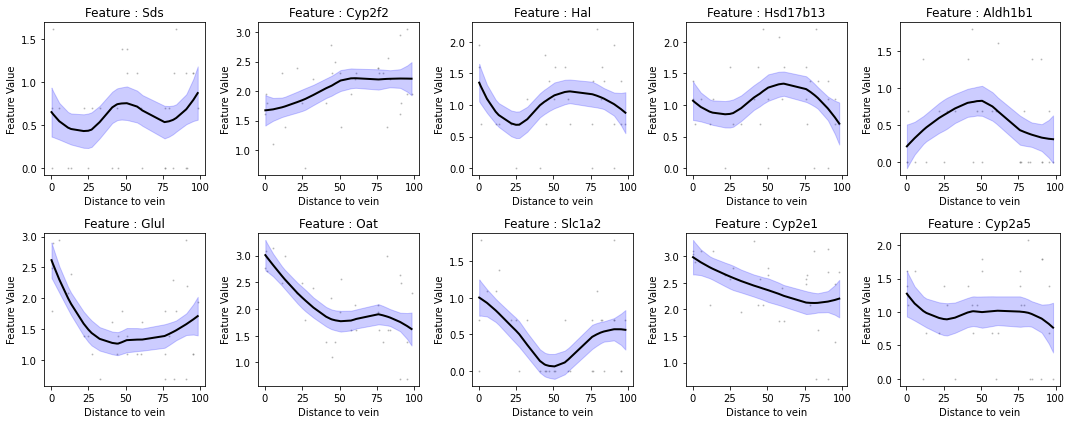

Vein : CN65-CCA-D1_6 | P(central) : 0.9186778042409547 | P(portal) : 0.0813221957590453


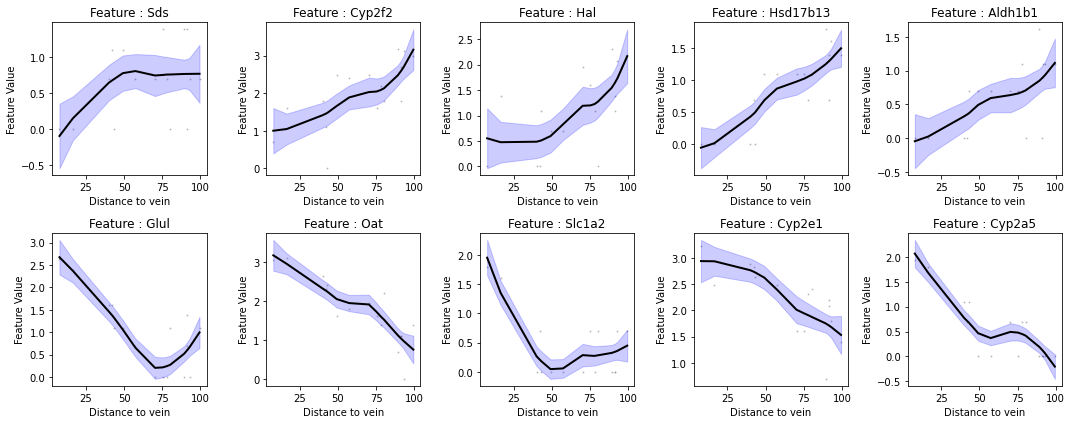

Vein : CN65-CCA-D1_7 | P(central) : 0.8690251073757065 | P(portal) : 0.13097489262429352


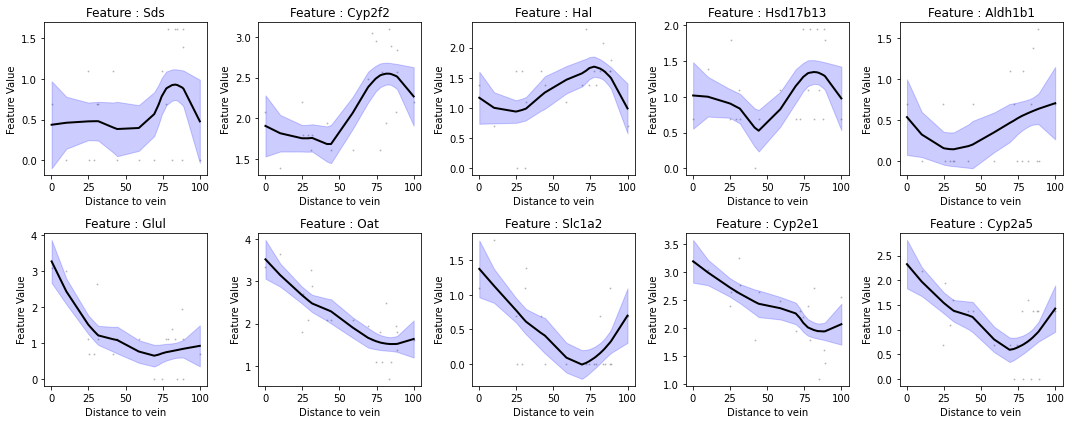

Vein : CN73-CCA-D1_15 | P(central) : 0.970025600898163 | P(portal) : 0.029974399101837


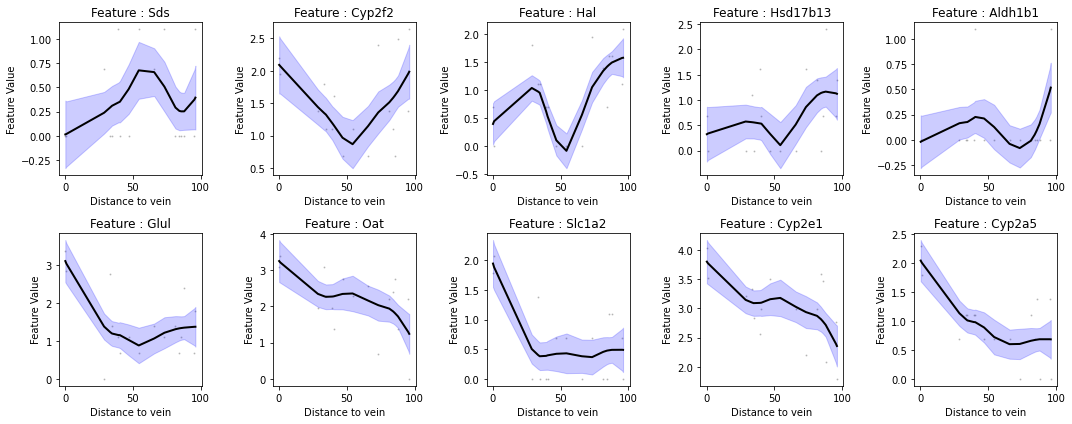

Vein : CN73-CCA-D1_16 | P(central) : 0.41294380529037444 | P(portal) : 0.5870561947096256


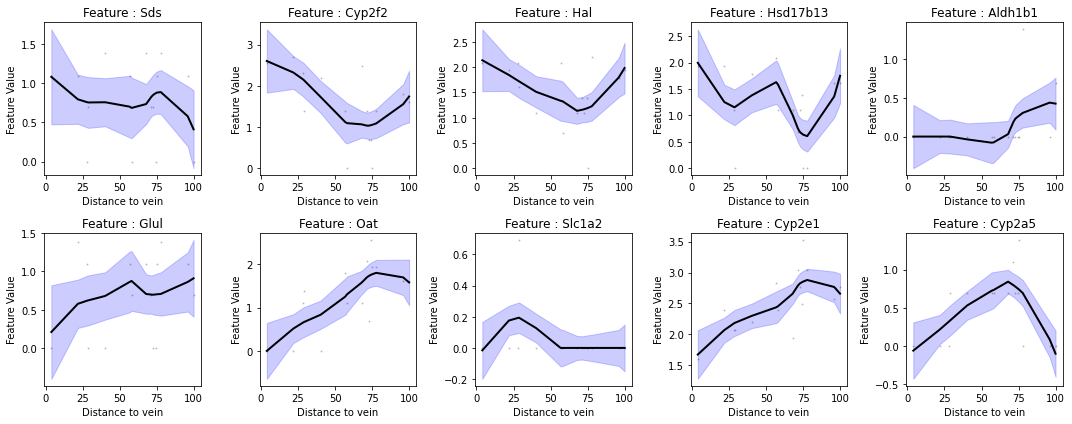

Vein : CN73-CCA-D1_17 | P(central) : 0.33894643008759506 | P(portal) : 0.6610535699124049


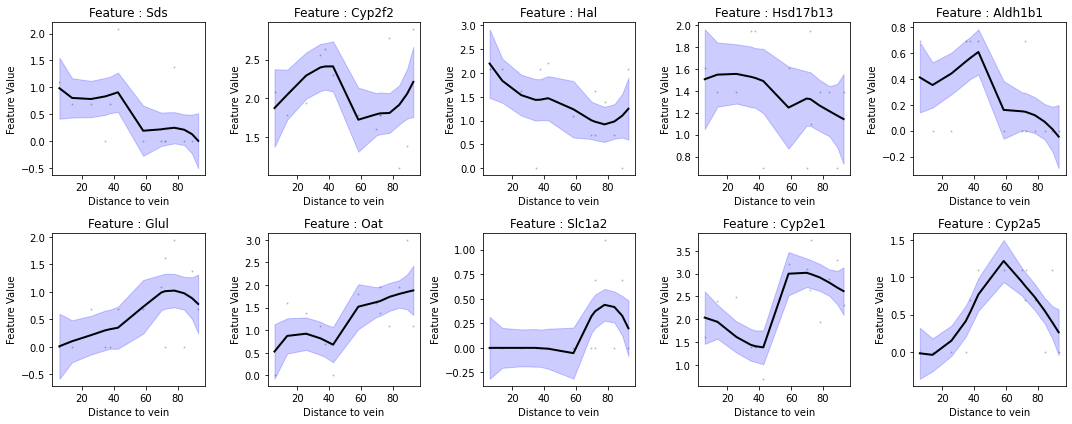

Vein : CN73-CCA-D1_18 | P(central) : 0.5215155987815151 | P(portal) : 0.4784844012184849


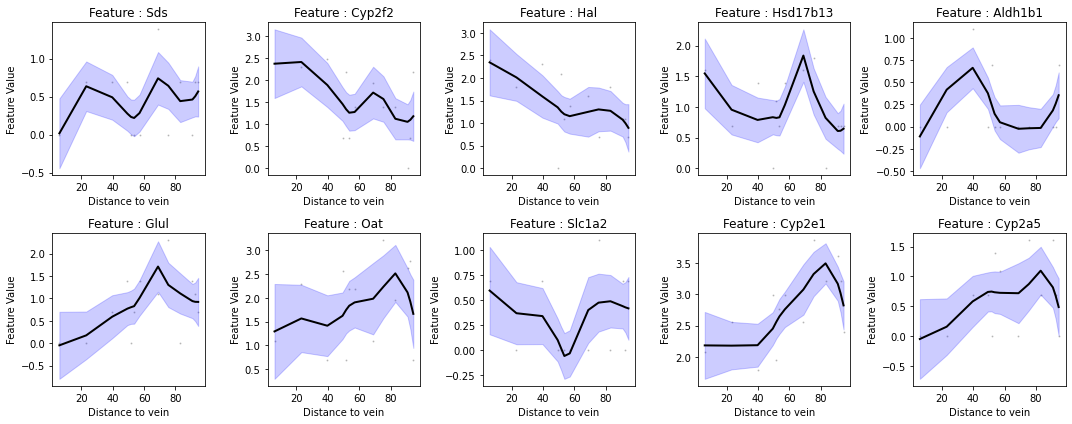

Vein : CN73-CCA-D1_19 | P(central) : 0.8892217187154653 | P(portal) : 0.11077828128453472


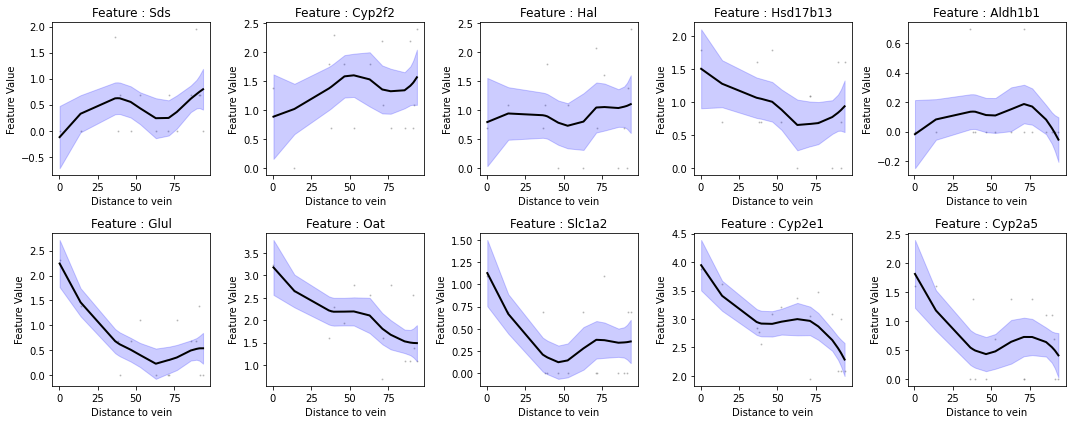

Vein : CN73-CCA-D1_20 | P(central) : 0.4419308352912146 | P(portal) : 0.5580691647087854


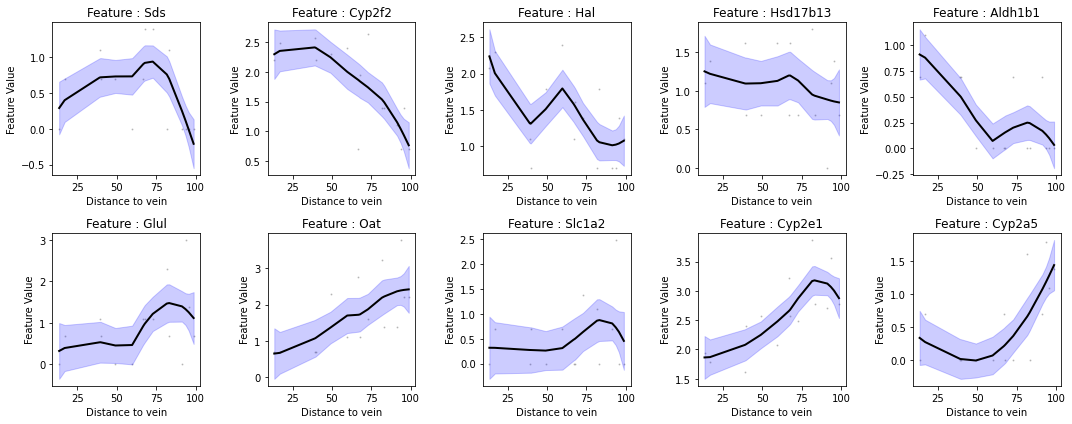

Vein : CN73-CCA-D1_21 | P(central) : 0.935518135933746 | P(portal) : 0.06448186406625403


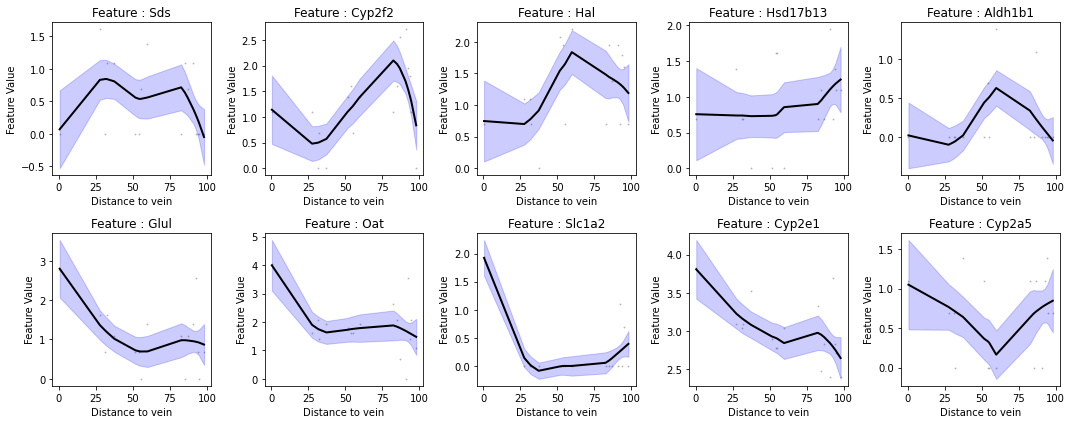

Vein : CN73-CCA-D1_22 | P(central) : 0.9072117151949493 | P(portal) : 0.09278828480505069


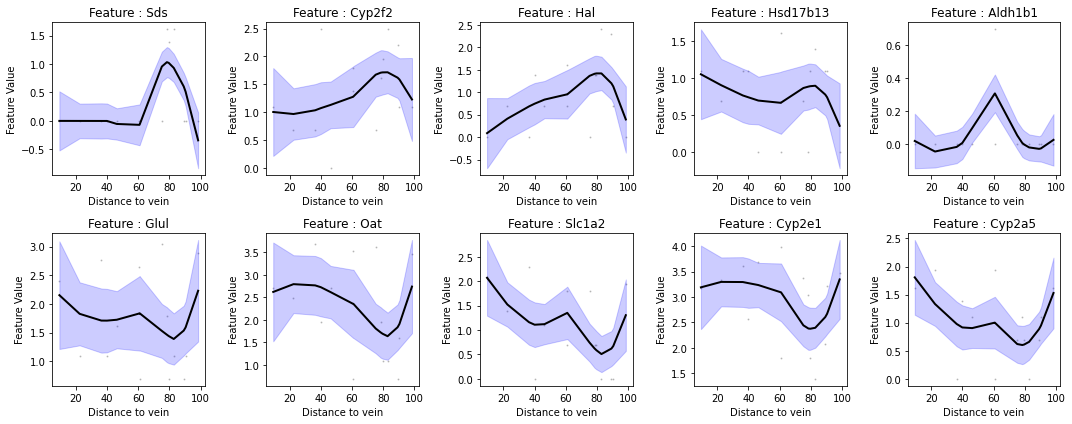

Vein : CN73-CCA-D1_23 | P(central) : 0.43366121620539266 | P(portal) : 0.5663387837946073


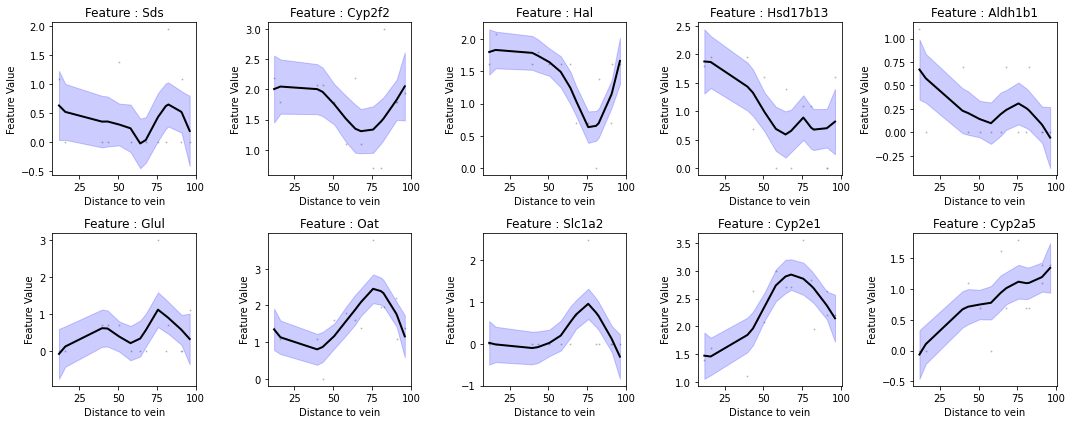

Vein : CN73-CCA-D1_24 | P(central) : 0.8661036877843724 | P(portal) : 0.13389631221562764


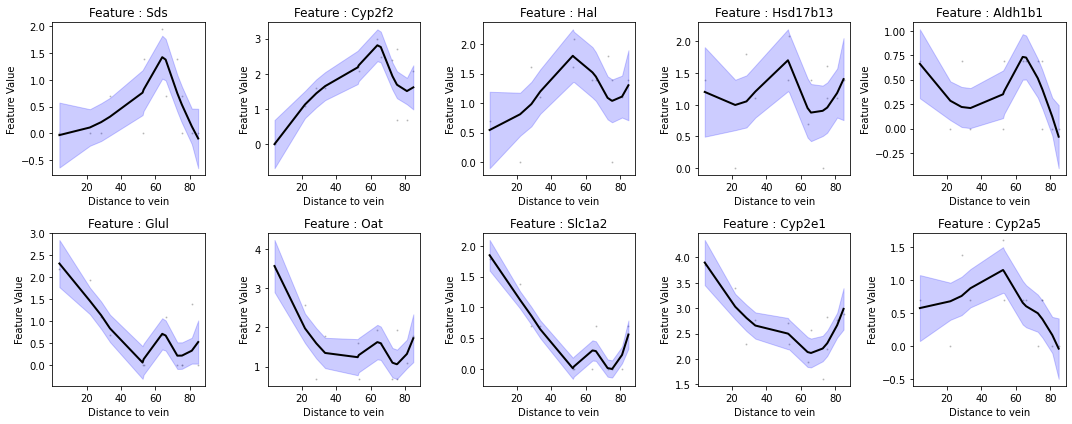

Vein : CN73-CCA-D1_25 | P(central) : 0.9293402797817266 | P(portal) : 0.07065972021827337


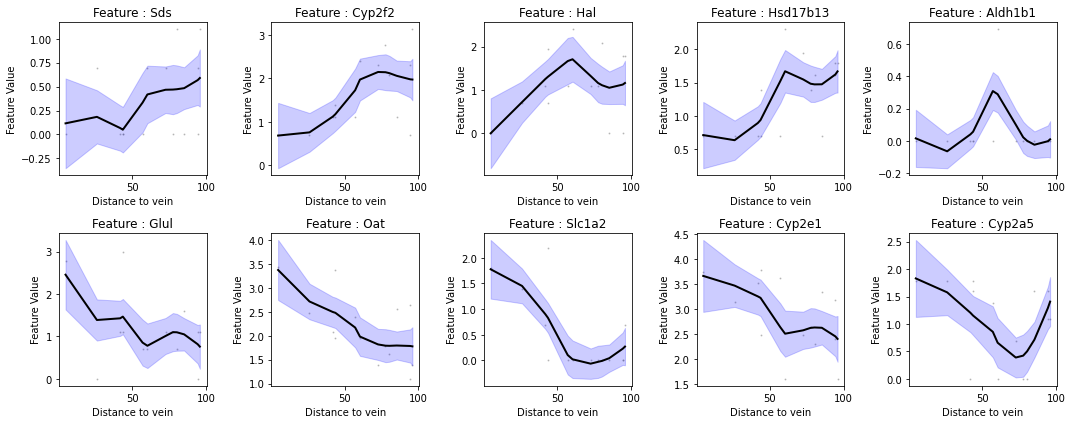

Vein : CN73-CCA-D1_26 | P(central) : 0.9670456134240831 | P(portal) : 0.03295438657591687


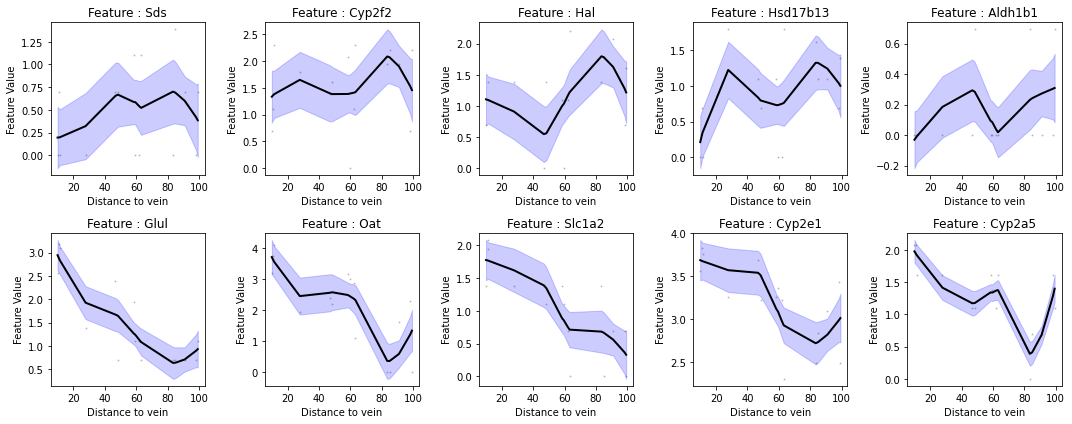

Vein : CN73-CCA-D1_27 | P(central) : 0.38046074765372384 | P(portal) : 0.6195392523462762


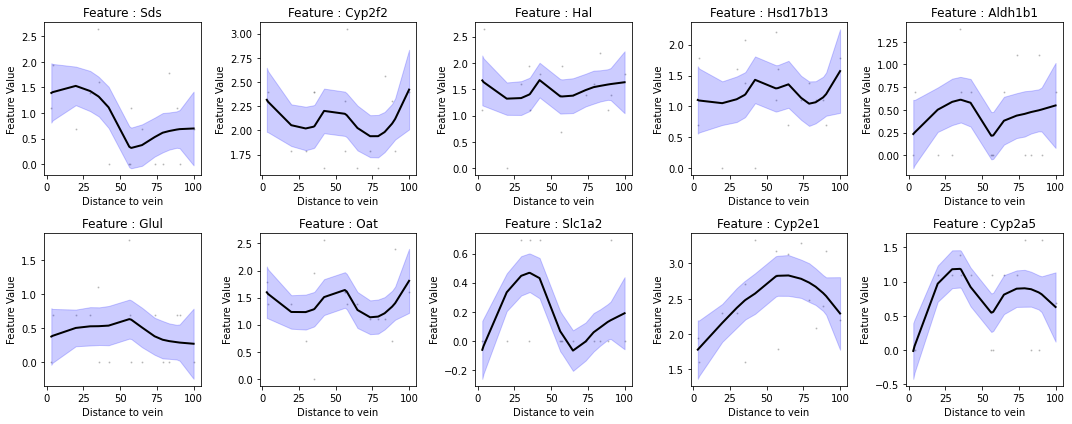

Vein : CN73-CCA-D1_28 | P(central) : 0.5613645141370425 | P(portal) : 0.4386354858629575


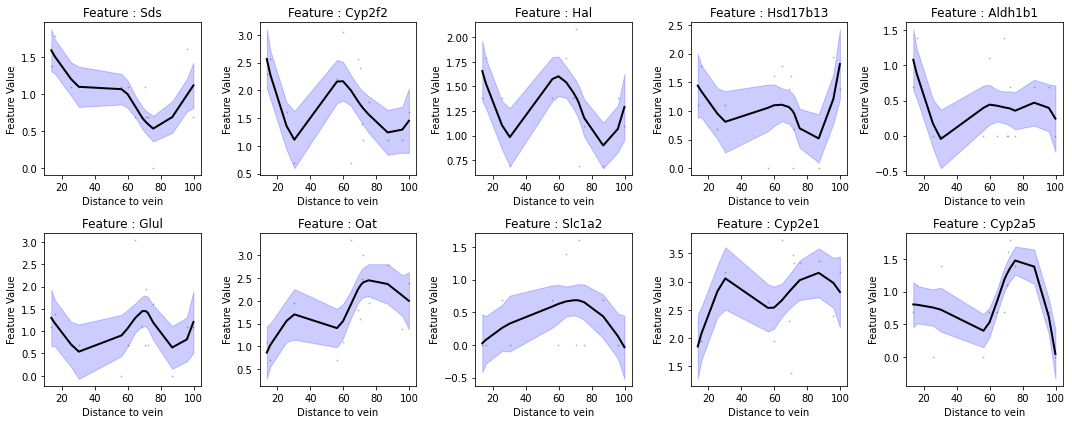

Vein : CN73-CCA-D1_29 | P(central) : 0.4846977835236991 | P(portal) : 0.5153022164763009


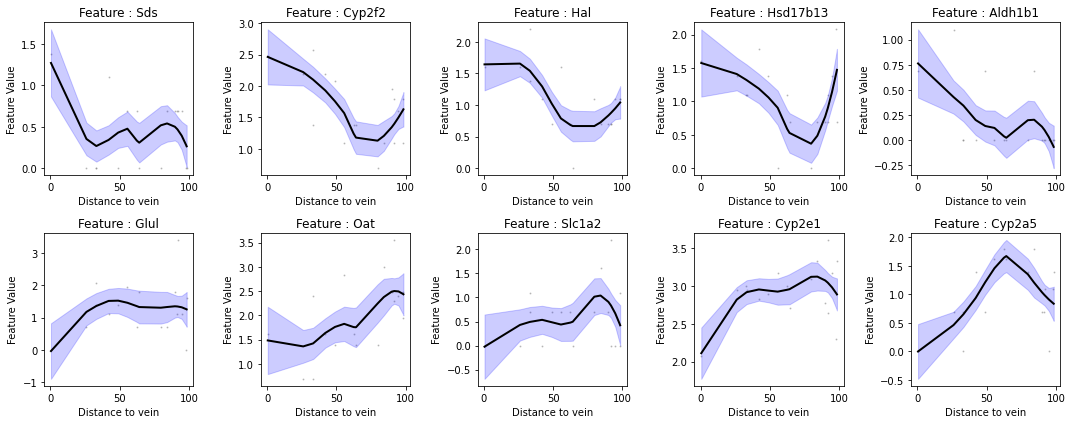

Vein : CN73-CCA-D1_30 | P(central) : 0.4317935190031217 | P(portal) : 0.5682064809968783


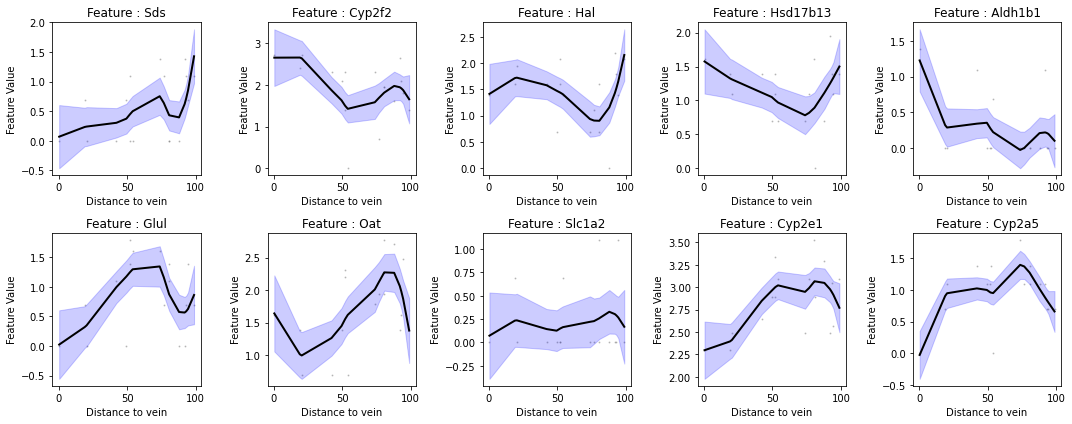

Vein : CN73-CCA-D1_31 | P(central) : 0.8734519110159675 | P(portal) : 0.12654808898403247


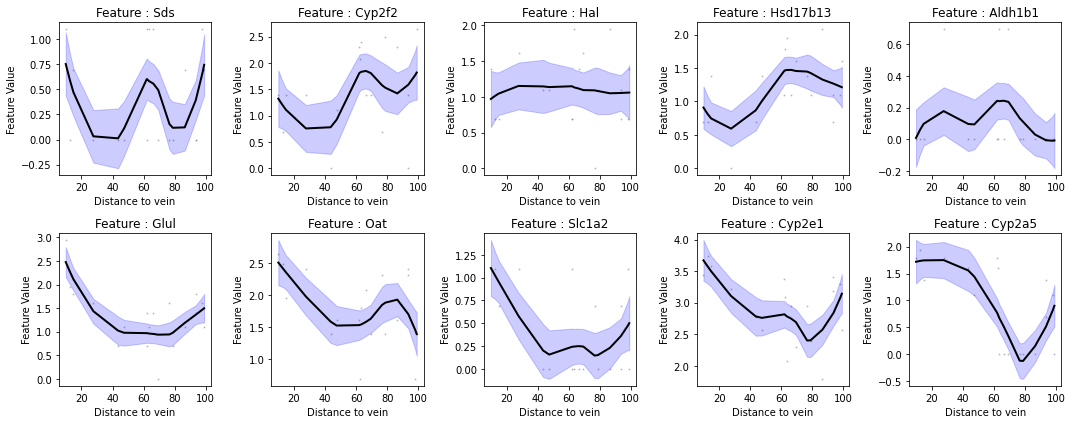

Vein : CN73-CCA-D1_32 | P(central) : 0.5567749139062106 | P(portal) : 0.44322508609378947


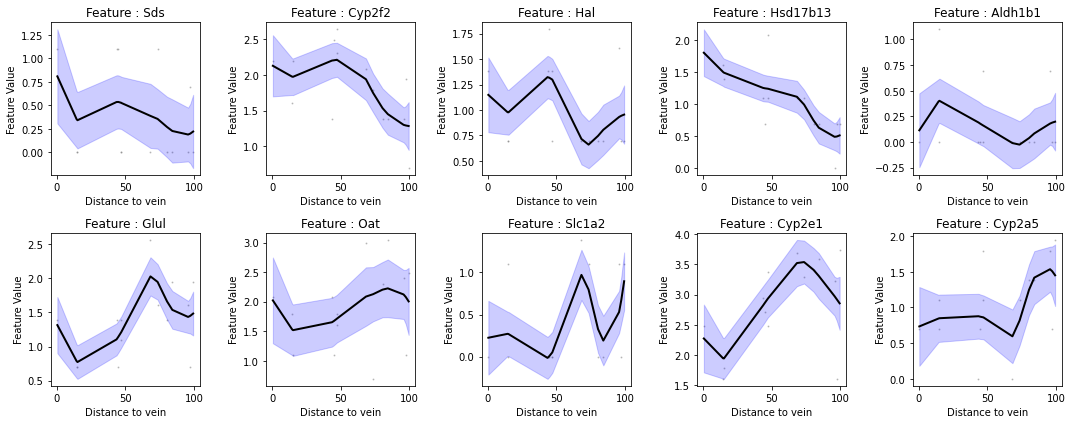

Vein : CN65-CCA-D2_7 | P(central) : 0.9523790248737547 | P(portal) : 0.047620975126245337


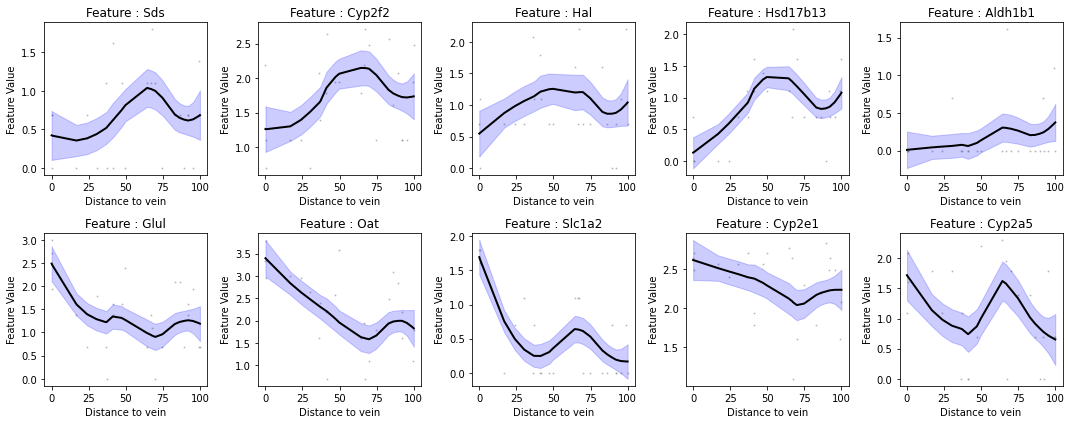

Vein : CN65-CCA-D2_8 | P(central) : 0.9661877325893541 | P(portal) : 0.03381226741064592


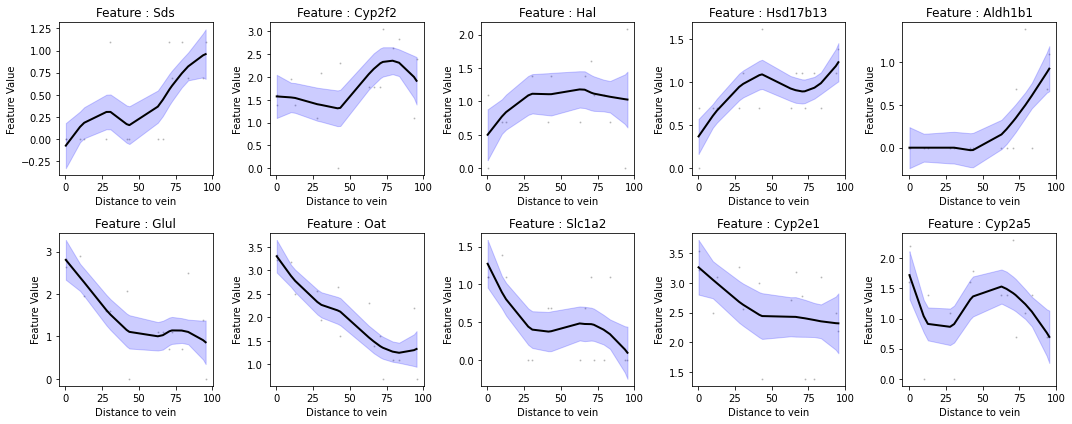

Vein : CN65-CCA-D2_9 | P(central) : 0.2916069447460249 | P(portal) : 0.7083930552539751


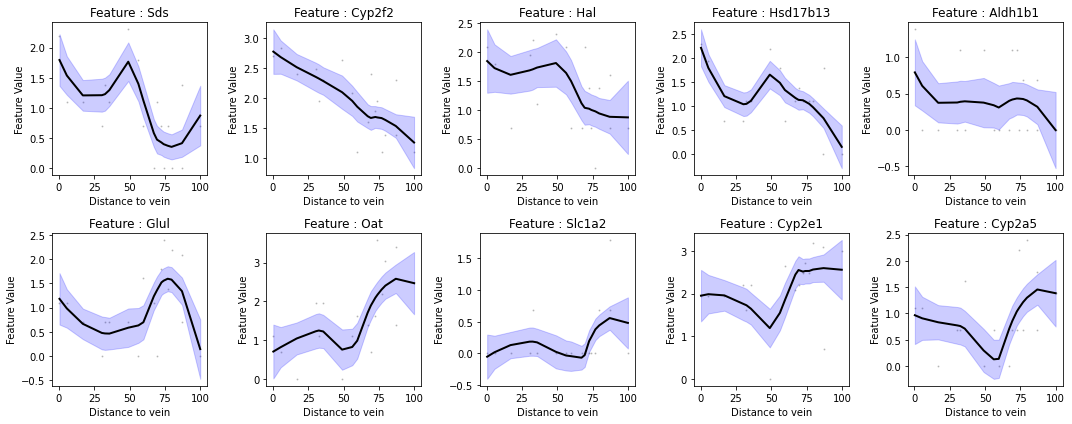

Vein : CN65-CCA-D2_10 | P(central) : 0.9481404851130542 | P(portal) : 0.05185951488694581


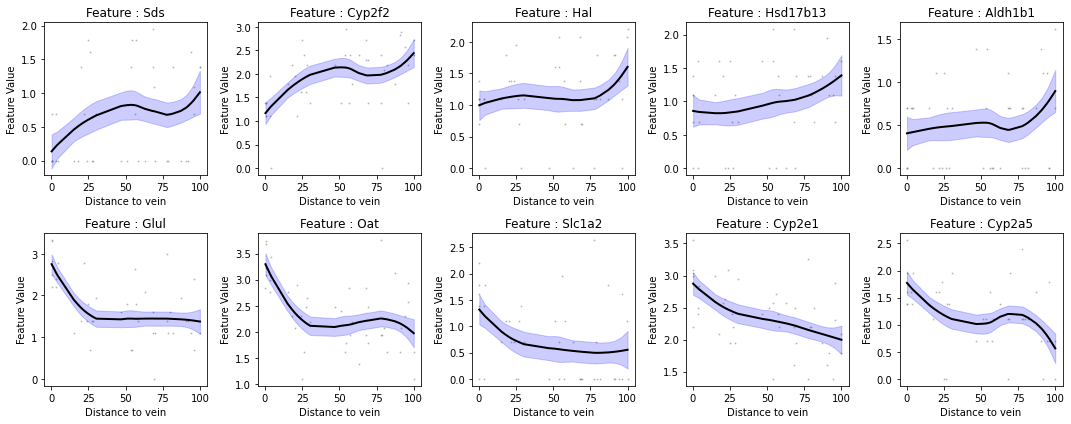

Vein : CN65-CCA-D2_11 | P(central) : 0.9551477048155415 | P(portal) : 0.0448522951844586


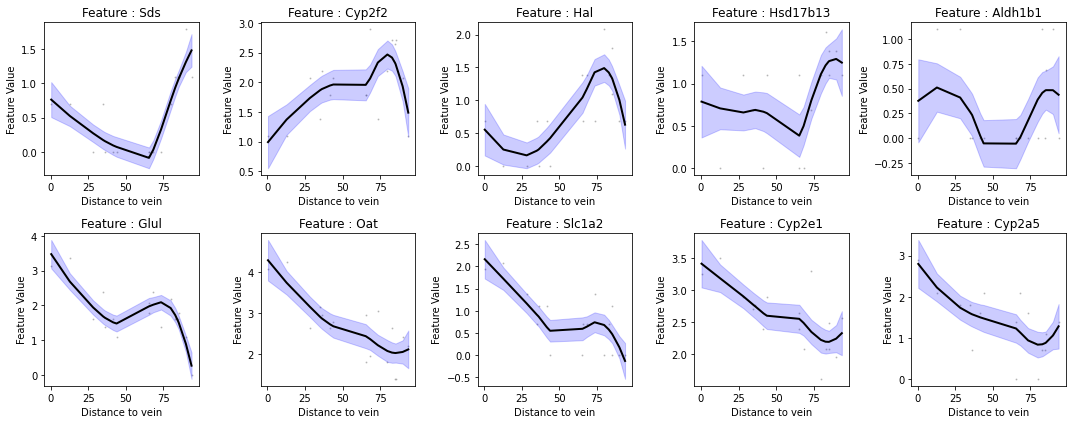

Vein : CN65-CCA-D2_12 | P(central) : 0.404400292139109 | P(portal) : 0.595599707860891


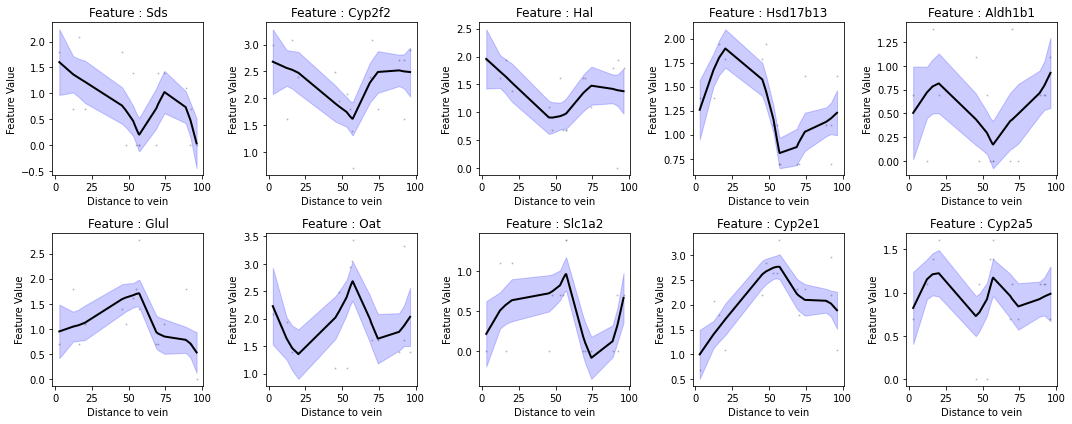

Vein : CN65-CCA-D2_13 | P(central) : 0.5210362981582769 | P(portal) : 0.4789637018417231


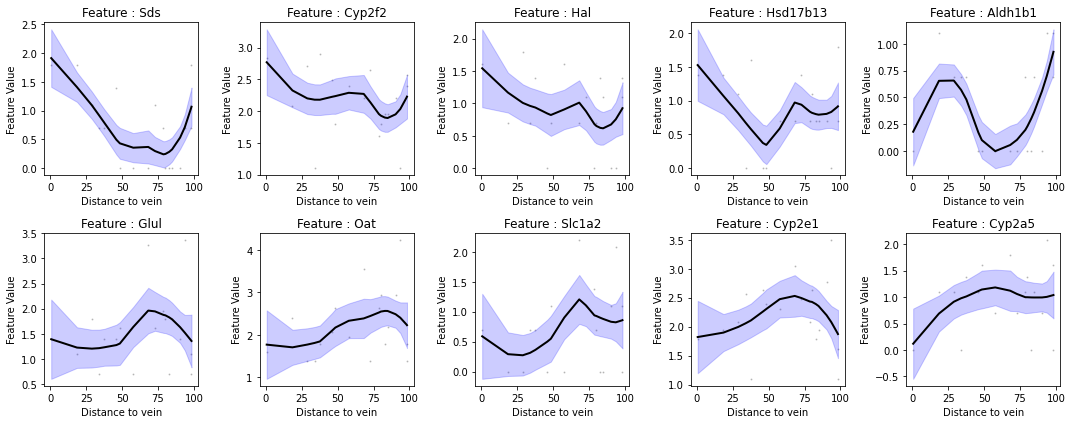

Vein : CN65-CCA-D2_14 | P(central) : 0.36333450673550727 | P(portal) : 0.6366654932644927


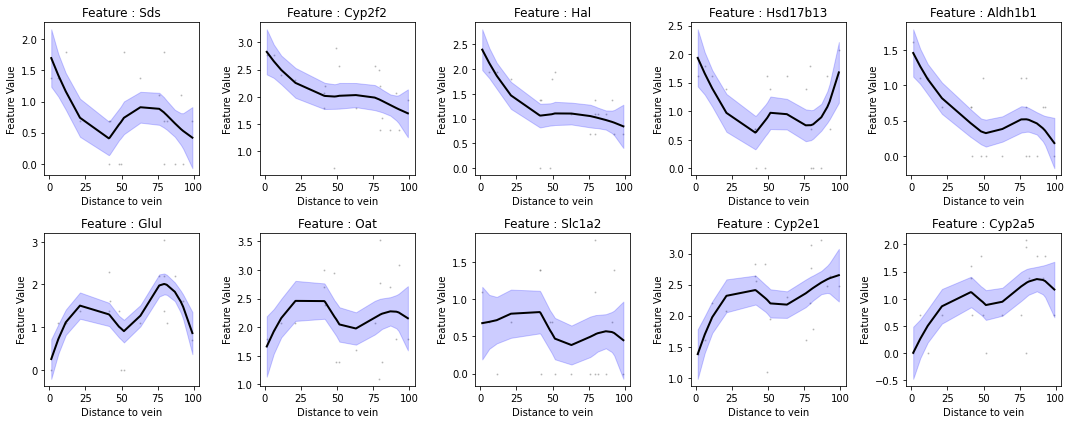

Vein : CN65-CCA-D2_15 | P(central) : 0.3755987623722531 | P(portal) : 0.6244012376277469


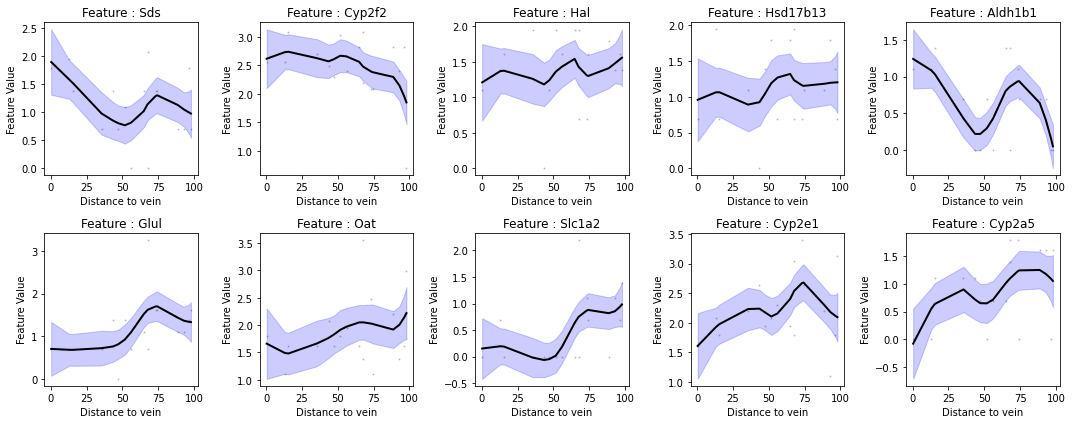

Vein : CN65-CCA-D2_16 | P(central) : 0.7155210775282574 | P(portal) : 0.2844789224717426


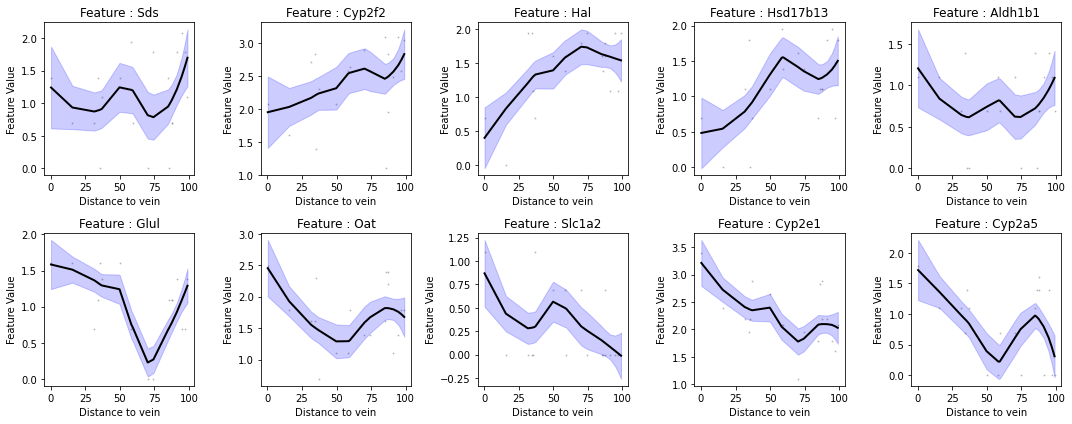

Vein : CN16-CCA-D1_38 | P(central) : 0.7406245583168722 | P(portal) : 0.2593754416831277


ValueError: b'Chernobyl! trL>n 6\n'

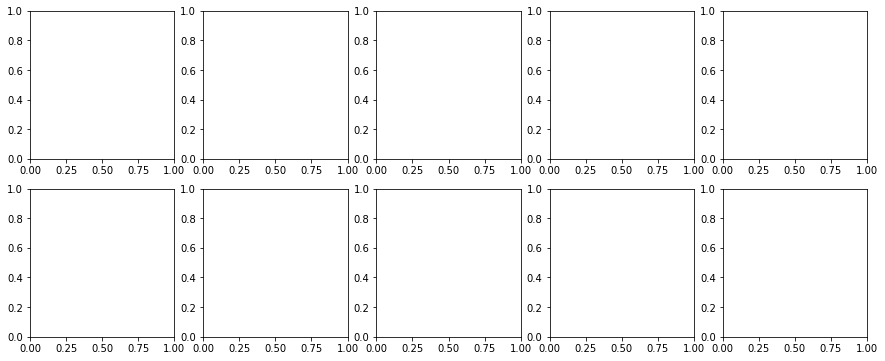

In [34]:


for vein_id in predict.index:
    pc,pp = predict.loc[vein_id,:]
    print("Vein : {} | P(central) : {} | P(portal) : {}".format(vein_id,
                                                                pc,
                                                                pp,
                                                               ))
    fig,ax = ut.get_figure(n_elements=len(vein_genes),
                          n_cols = 5,
                           side_size = 3,
                          )
    
    sample_id = vein_id.split("_")[0]
    
    crd = data_set[sample_id].obs[["x","y"]].values

    dists = vein_data.get_distance_to_vein(crd = crd,
                                           vein_id = vein_id)

    for k,gene in enumerate(vein_genes):
        expr = data_set[sample_id].obs_vector(gene)
        smoothed = ut.smooth_fit(dists,expr,dist_thrs=100)
        
        ut.plot_expression_by_distance(ax[k],
                                       smoothed,
                                       feature = gene,
                                      )
    
    fig.tight_layout()
    plt.show()
        
    

In [36]:
predict_all = model.predict(predict_on="all",
                            return_probs = False,
                        )

predict_all

all


vein_type
CN73-CCA-C1_0    central
CN73-CCA-C1_1     portal
CN73-CCA-C1_2    central
CN73-CCA-C1_3    central
CN73-CCA-C1_4    central
...                  ...
CN73-CCA-E2_33    portal
CN73-CCA-E2_34   central
CN73-CCA-E2_35    portal
CN73-CCA-E2_36   central
CN73-CCA-E2_37    portal

[306 rows x 1 columns]

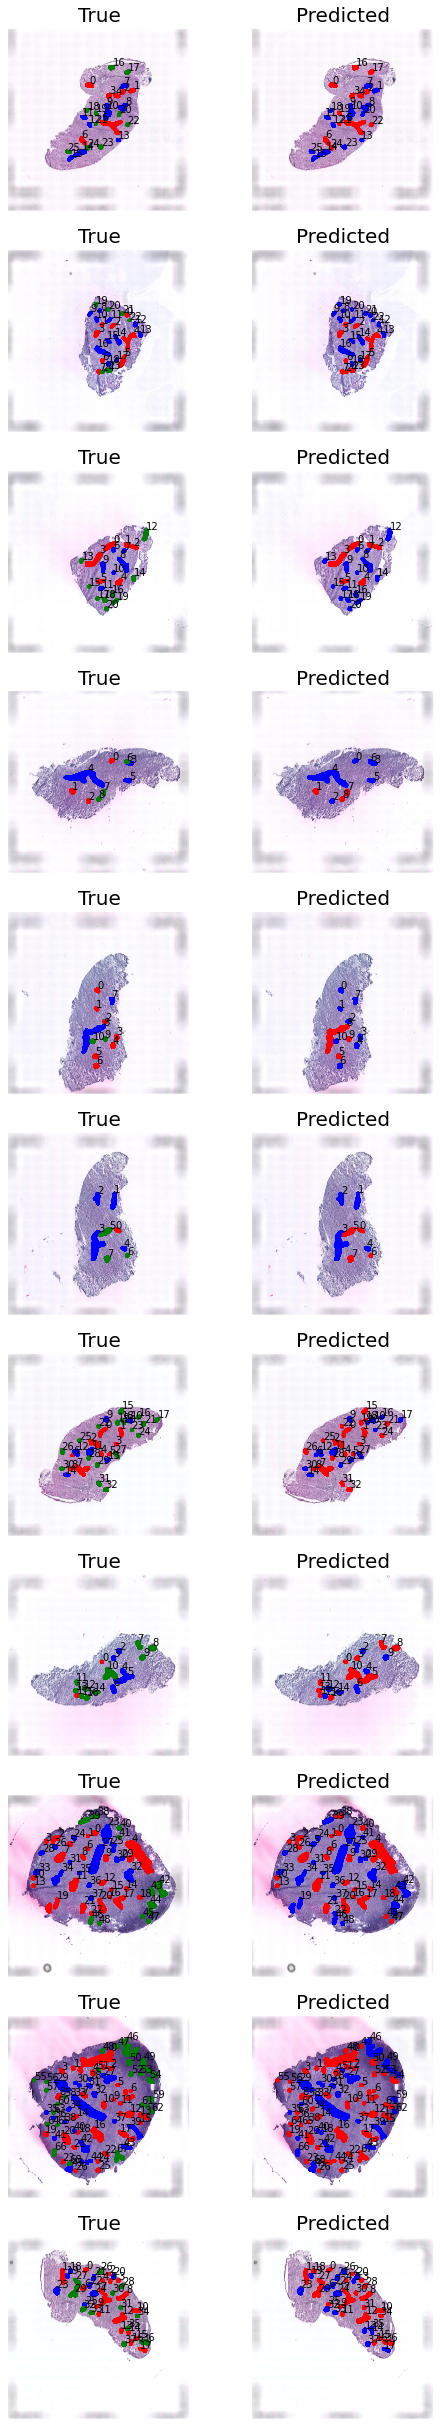

In [38]:
# instantiate plot
fig,ax = plt.subplots(len(data_set),2,
                      figsize = (4 * 2,4 * len(data_set)))

cmap = {"central":"red",
        "portal":"blue",
        "unknown":"green"}


for k,sample_id in enumerate(data_set.keys()):
  
    # convert predicted type to vector
    # with label for each pixel
    
    true_color = data_set[sample_id].uns["mask"].type.map(cmap).values.flatten()
    pred_color = data_set[sample_id].uns["mask"].type.map(cmap).values.flatten()
    
    idxs = data_set[sample_id].uns["mask"].id.values
    
    for idx in np.unique(idxs):
        sel = idxs == idx
        vein_id = sample_id + "_" + str(idx)
        pred_color[sel] = cmap[predict_all.loc[vein_id].values[0]]
        
    
    ut.plot_veins(ax[k,0],
                  data_set[sample_id],
                  alternative_colors = true_color,
                  show_image = True,
                  show_id = True,
                 )
    
    ut.plot_veins(ax[k,1],
                  data_set[sample_id],
                  alternative_colors = pred_color,
                  show_image = True,
                  show_id = True,
                 )
    
    # set titles
    ax[k,0].set_title("True",
                    fontsize = 20,)
    ax[k,1].set_title("Predicted",
                    fontsize = 20,)
    
    ax[k,0].set_ylabel(sample_id,
                       fontsize = 20)



plt.show()